In [ ]:
import os
from google.colab import drive
drive.mount('/content/driver')

Mounted at /content/driver


In [ ]:
path = '/content/drive/MyDrive/annotated dataset'
print(os.listdir(path))

['data.yaml', 'train', 'test', 'valid']


In [ ]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 15921, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 15921 (delta 15), reused 20 (delta 8), pack-reused 15880
Receiving objects: 100% (15921/15921), 14.66 MiB | 16.16 MiB/s, done.
Resolving deltas: 100% (10910/10910), done.


In [ ]:
%cd yolov5/

/content/yolov5


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.0/613.0 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00


In [ ]:
import torch
from pathlib import Path
from models.yolo import attempt_load

In [ ]:
from torchvision.transforms import functional as F
from PIL import Image
from tqdm import tqdm
import numpy as np

In [ ]:
import os
import shutil

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-210-gdd10481 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 263MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [ ]:
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = F.resize(img, (640, 640))
    img = F.pad(img, (0, 0, 640 - img.width, 640 - img.height), 0)
    img = F.to_tensor(img)
    img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = img.unsqueeze(0)  # Add batch dimension
    return img

In [ ]:
def extract_features(model, image_path):
    img = preprocess_image(image_path)

    # Run inference
    with torch.no_grad():
        detections = model(img)[0]

    return detections

In [ ]:
import glob

In [ ]:
dataset_path = "/content/drive/MyDrive/annotated dataset/train/images"
image_files = glob.glob(os.path.join(dataset_path, "*.jpg"))

for image_file in image_files:
    detections = extract_features(model, image_file)

In [ ]:
detections.shape

torch.Size([25200, 85])

In [ ]:
detections

tensor([[5.98328e+00, 5.44964e+00, 1.12805e+01,  ..., 1.82327e-03, 8.60664e-04, 3.14927e-03],
        [1.13155e+01, 6.82000e+00, 2.30335e+01,  ..., 1.71693e-03, 8.96992e-04, 2.46367e-03],
        [1.79564e+01, 6.00670e+00, 2.97118e+01,  ..., 1.73223e-03, 9.15799e-04, 3.62887e-03],
        ...,
        [5.60295e+02, 6.02820e+02, 1.45167e+02,  ..., 4.19796e-03, 1.89614e-03, 1.76052e-03],
        [5.85790e+02, 6.05081e+02, 1.14485e+02,  ..., 3.85120e-03, 1.36091e-03, 1.48676e-03],
        [6.18875e+02, 6.11326e+02, 1.30154e+02,  ..., 3.79188e-03, 1.34346e-03, 1.39356e-03]], device='cuda:0')

In [ ]:
# Training configuration
dataset_path = "/content/drive/MyDrive/annotated dataset/train/images"
annotations_path = "/content/drive/MyDrive/annotated dataset/train/labels"
batch_size = 50
epochs = 10
learning_rate = 0.001

In [ ]:
# Create necessary directories
os.makedirs(annotations_path, exist_ok=True)

In [ ]:
# Prepare training data
image_files = glob.glob(os.path.join(dataset_path, "*.jpg"))
train_txt_path = os.path.join(annotations_path, "train.txt")
with open(train_txt_path, "w") as f:
    for image_file in image_files:
        f.write(image_file + "\n")

In [ ]:
# Start training
command = f"python train.py --img 640 --batch {batch_size} --epochs {epochs} --data coco.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --name yolov5s_result"
os.system(command)

0

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/yolov5s_result/weights/best.pt --source "/content/drive/MyDrive/annotated dataset/test/images/00005_jpg.rf.9f43b17a934d97c72d07d4ca38e167c5.jpg" --conf-thres 0.015 --imgsz 640


detect: weights=['/content/yolov5/runs/train/yolov5s_result/weights/best.pt'], source=/content/drive/MyDrive/annotated dataset/test/images/00005_jpg.rf.9f43b17a934d97c72d07d4ca38e167c5.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.015, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-210-gdd10481 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/annotated dataset/test/images/00005_jpg.rf.9f43b17a934d97c72d07d4ca38e167c5.jpg: 640x640 3 Cracks, 1 Non_Crack, 11.6ms
Speed: 0.9ms pre-process, 11.6ms inference, 88.2ms NMS per image at shape (1, 3, 

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/yolov5s_result/weights/best.pt --source "/content/drive/MyDrive/annotated dataset/test/images/00011_jpg.rf.b610d7e2d5f7b5029270a32f736fbd1a.jpg" --conf-thres 0.015 --imgsz 640


detect: weights=['/content/yolov5/runs/train/yolov5s_result/weights/best.pt'], source=/content/drive/MyDrive/annotated dataset/test/images/00011_jpg.rf.b610d7e2d5f7b5029270a32f736fbd1a.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.015, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-210-gdd10481 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/annotated dataset/test/images/00011_jpg.rf.b610d7e2d5f7b5029270a32f736fbd1a.jpg: 640x640 3 Cracks, 11.6ms
Speed: 0.8ms pre-process, 11.6ms inference, 84.6ms NMS per image at shape (1, 3, 640, 640)
Res

In [ ]:
root_path = '/content/drive/MyDrive/PR_RESULT'

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'best.pt')

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'best.pt'))
    print('Trained Model Loaded')

Trained Model Loaded


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
image_path = "/content/yolov5/runs/train/yolov5s_results/confusion_matrix.png"


In [ ]:
from PIL import Image, ImageDraw
from IPython.display import display

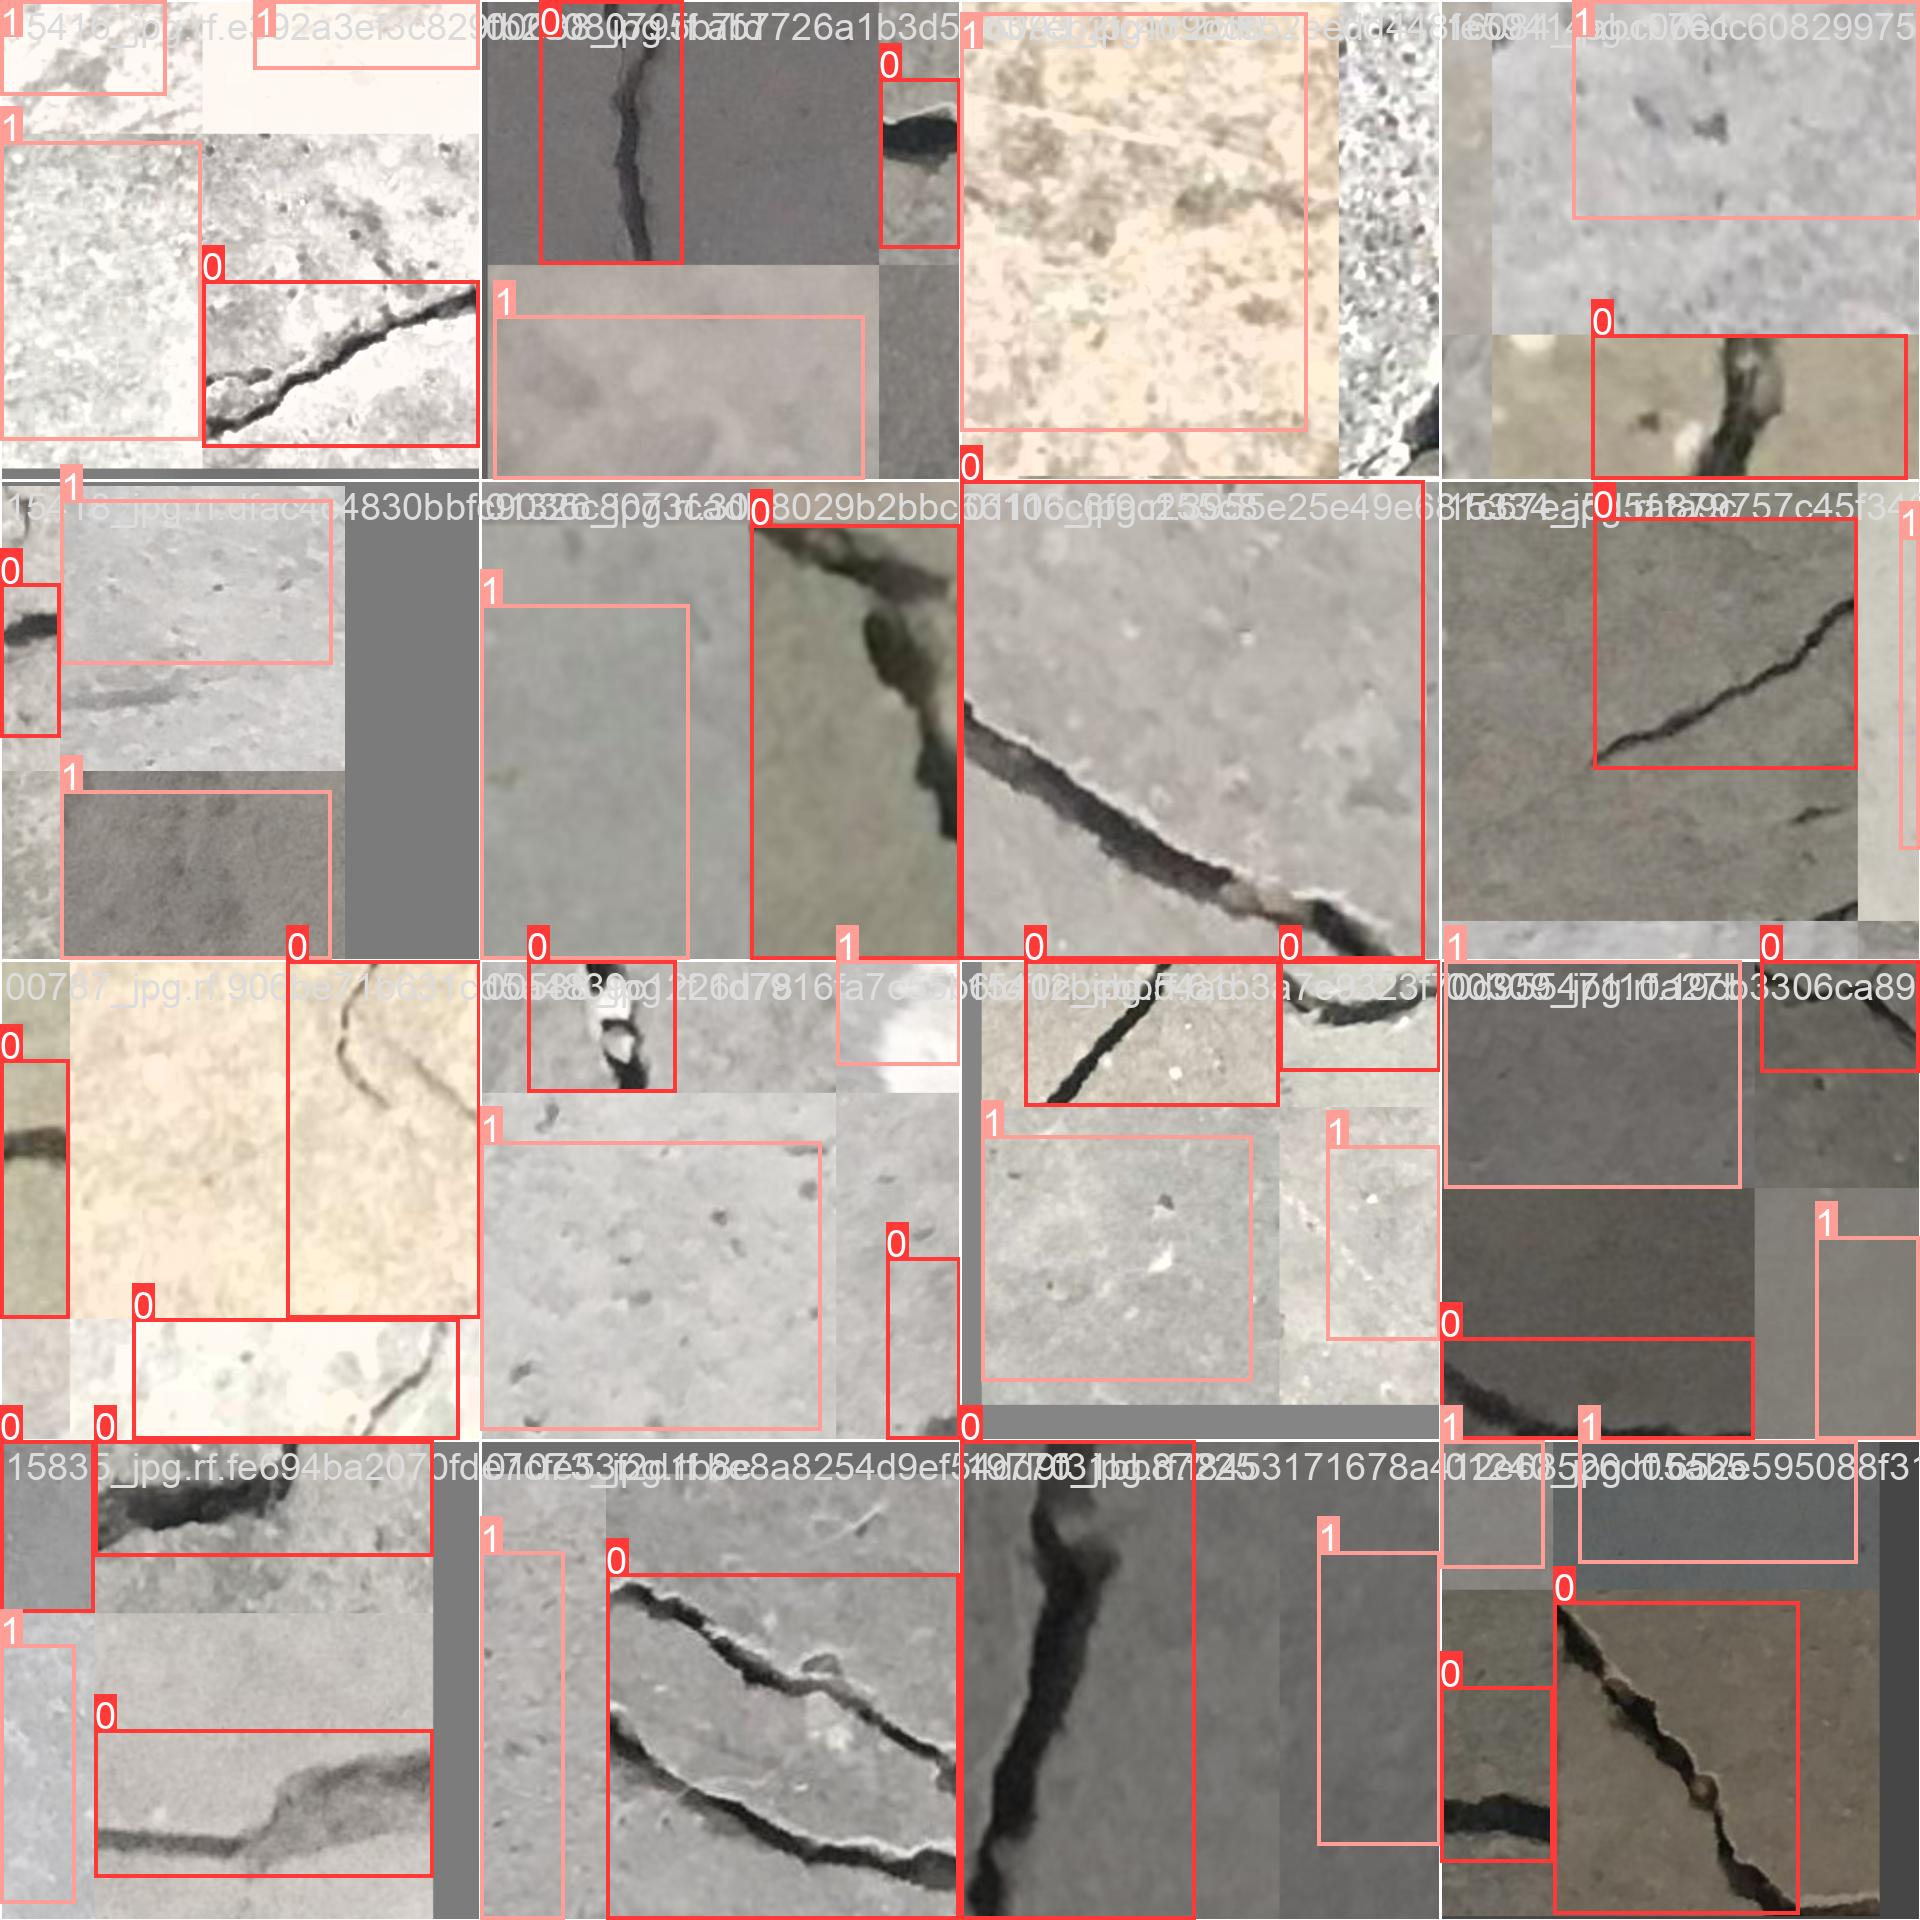

In [ ]:
from PIL import Image
from IPython.display import display

# Load the PNG image using Image.open() from PIL
# Replace 'your_image.png' with the path to your PNG image file
image_path = '/content/yolov5/runs/train/yolov5s_result/train_batch1.jpg'
img = Image.open(image_path)

# Display the image using IPython.display
display(img)

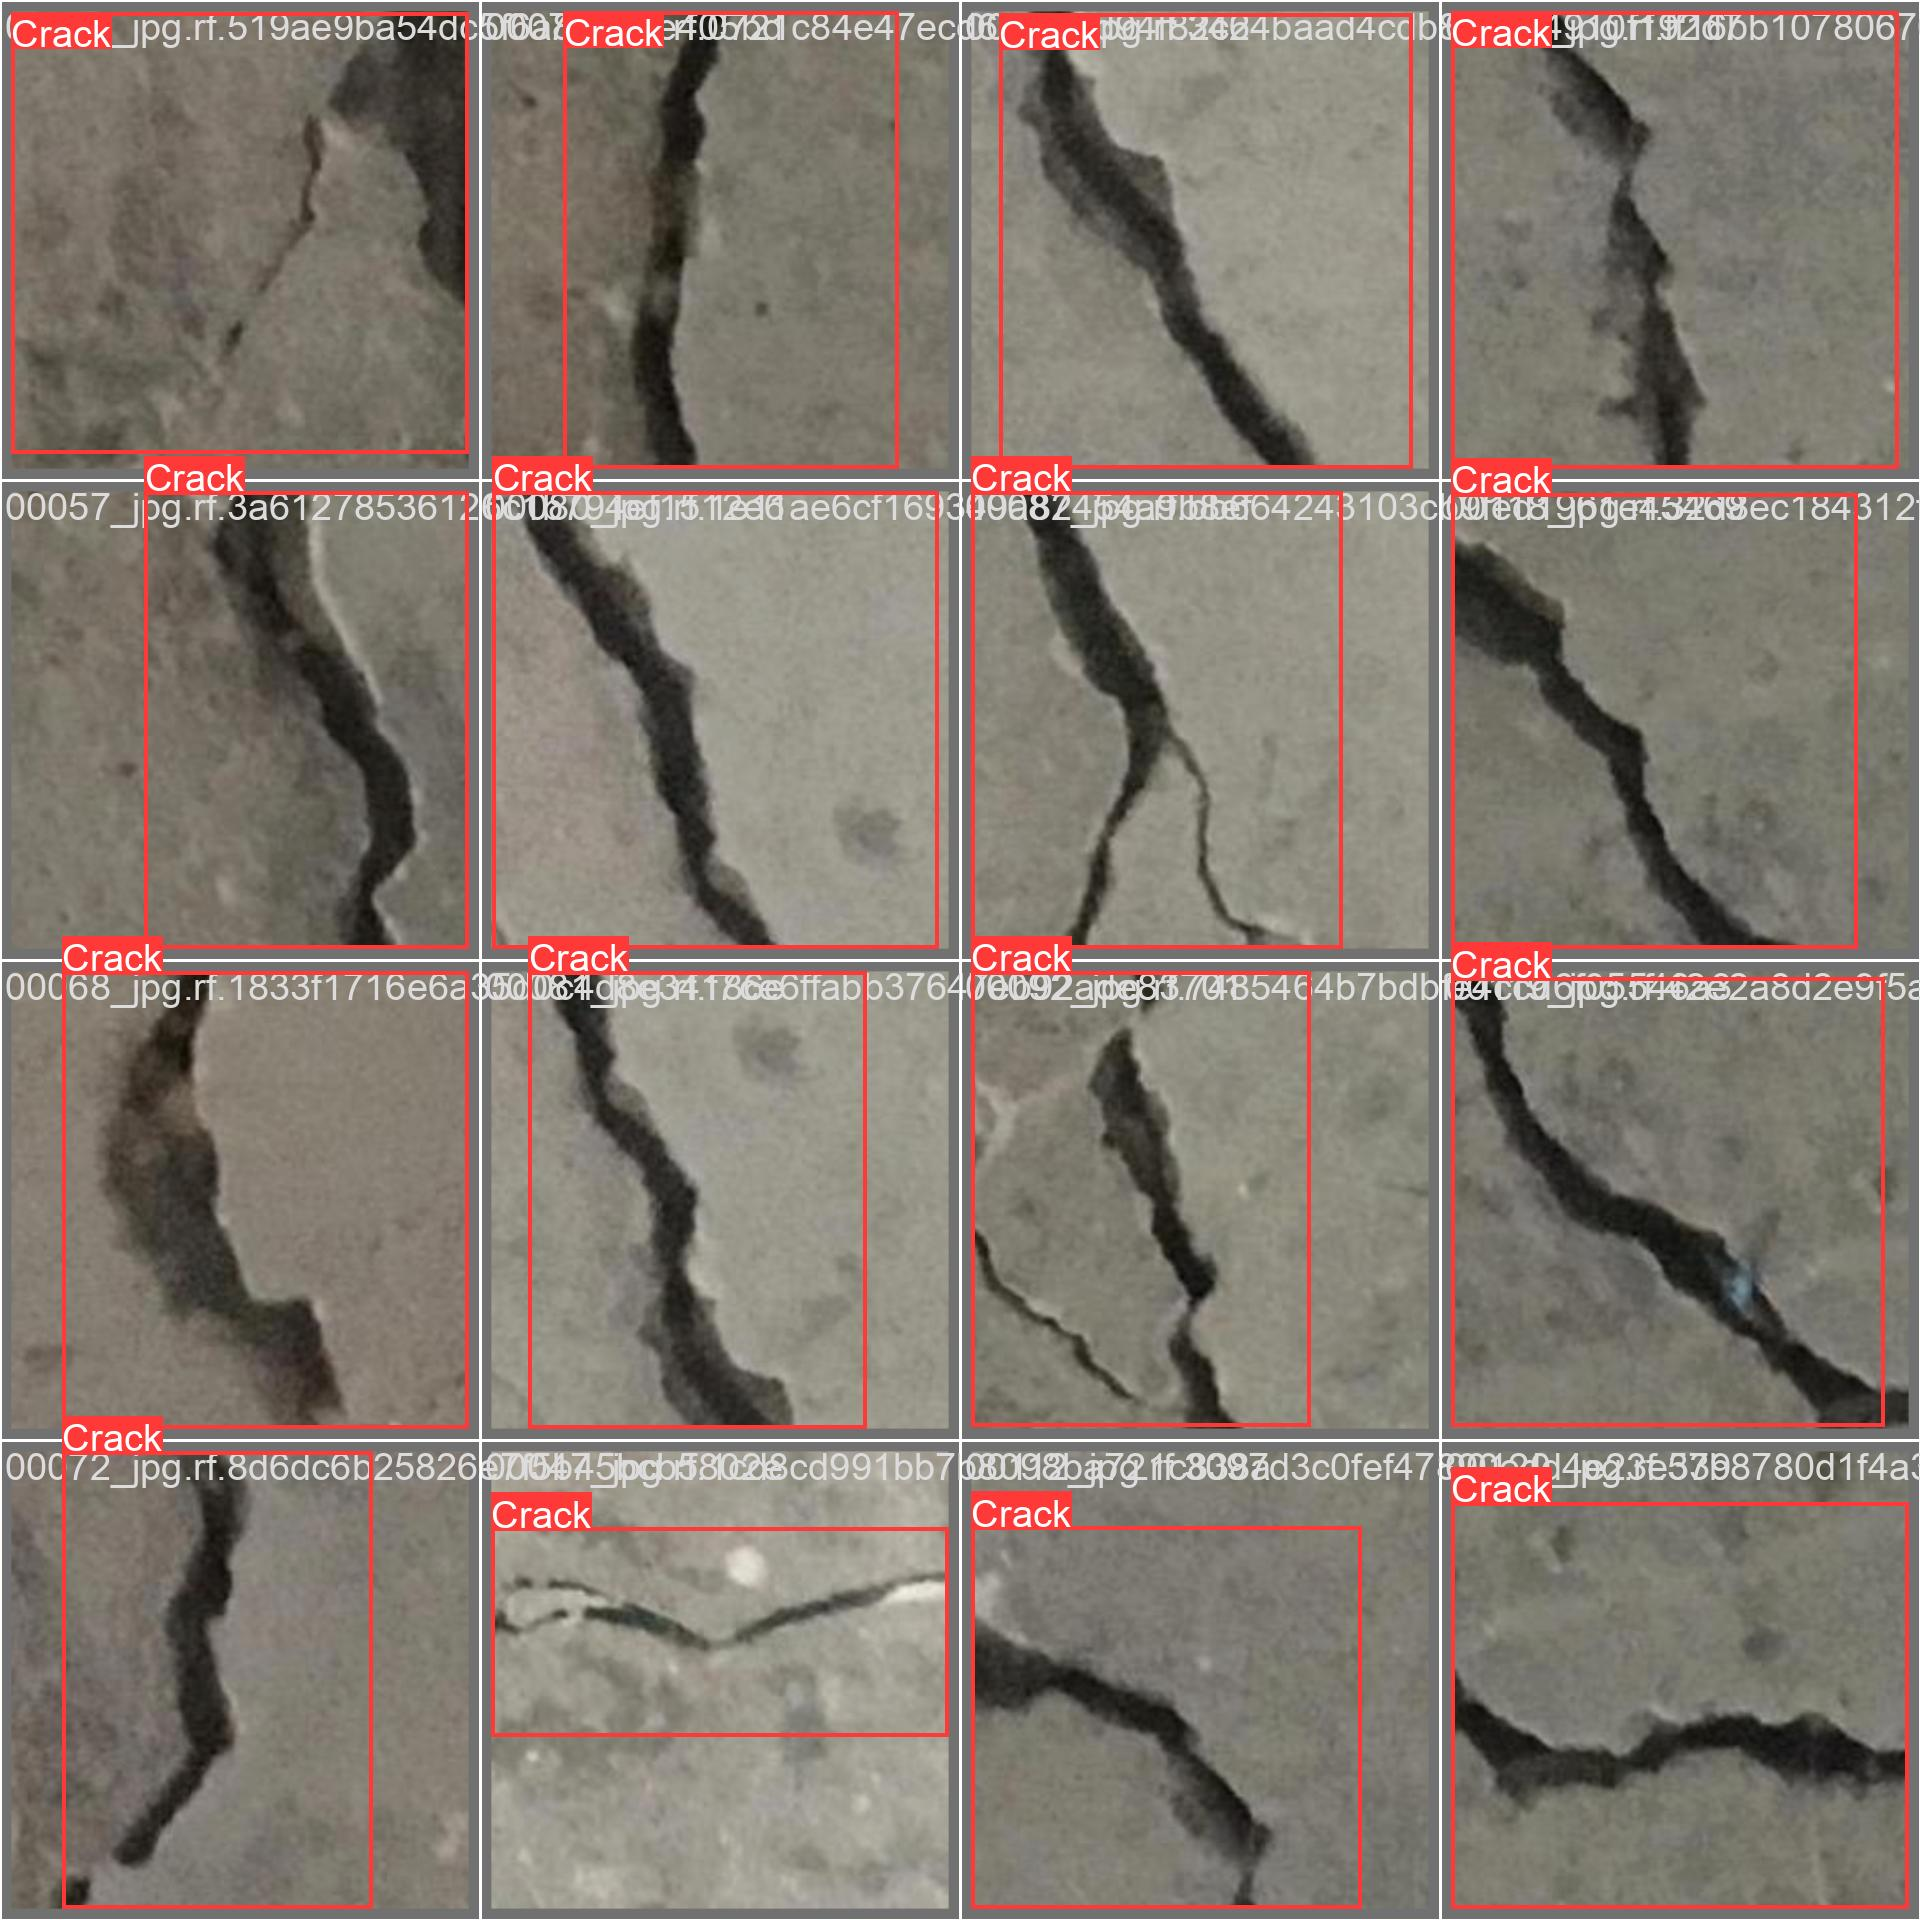

In [ ]:
image_path = '/content/yolov5/runs/train/yolov5s_result/val_batch1_labels.jpg'
img = Image.open(image_path)
# Display the image using IPython.display
display(img)

draw = ImageDraw.Draw(img)
label='Validation'
plt.legend();

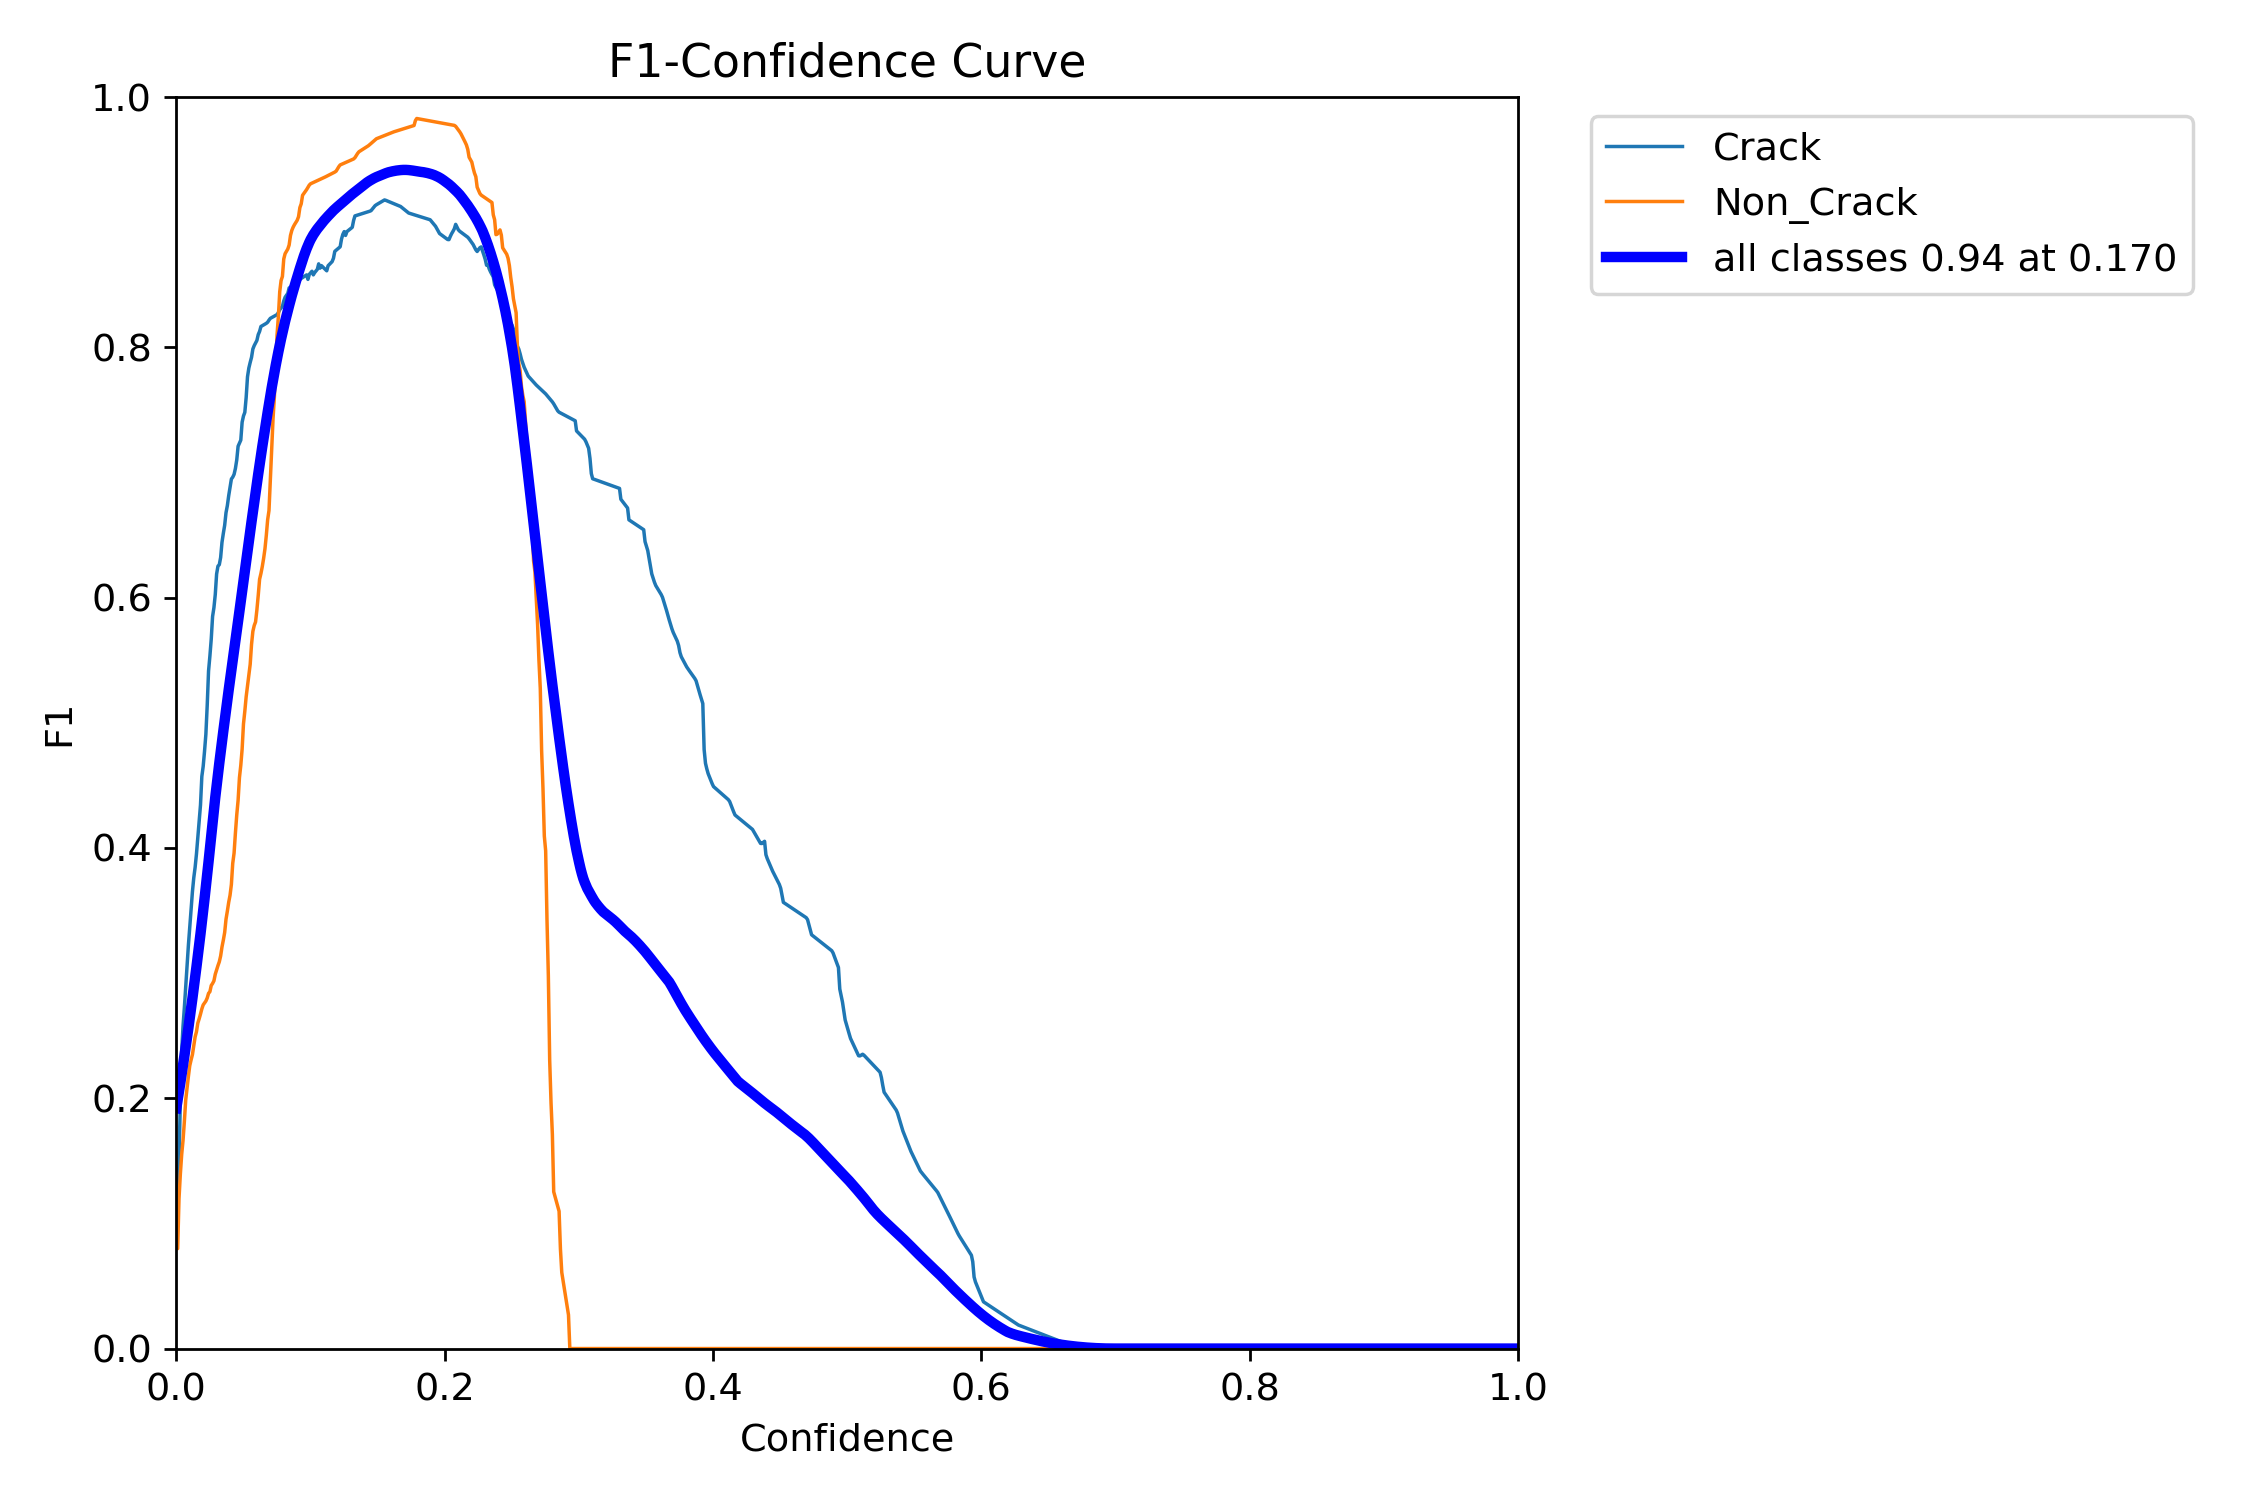

In [ ]:
from PIL import Image
from IPython.display import display

# Load the PNG image using Image.open() from PIL
# Replace 'your_image.png' with the path to your PNG image file
image_path = '/content/yolov5/runs/train/yolov5s_result/F1_curve.png'
img = Image.open(image_path)

# Display the image using IPython.display
display(img)


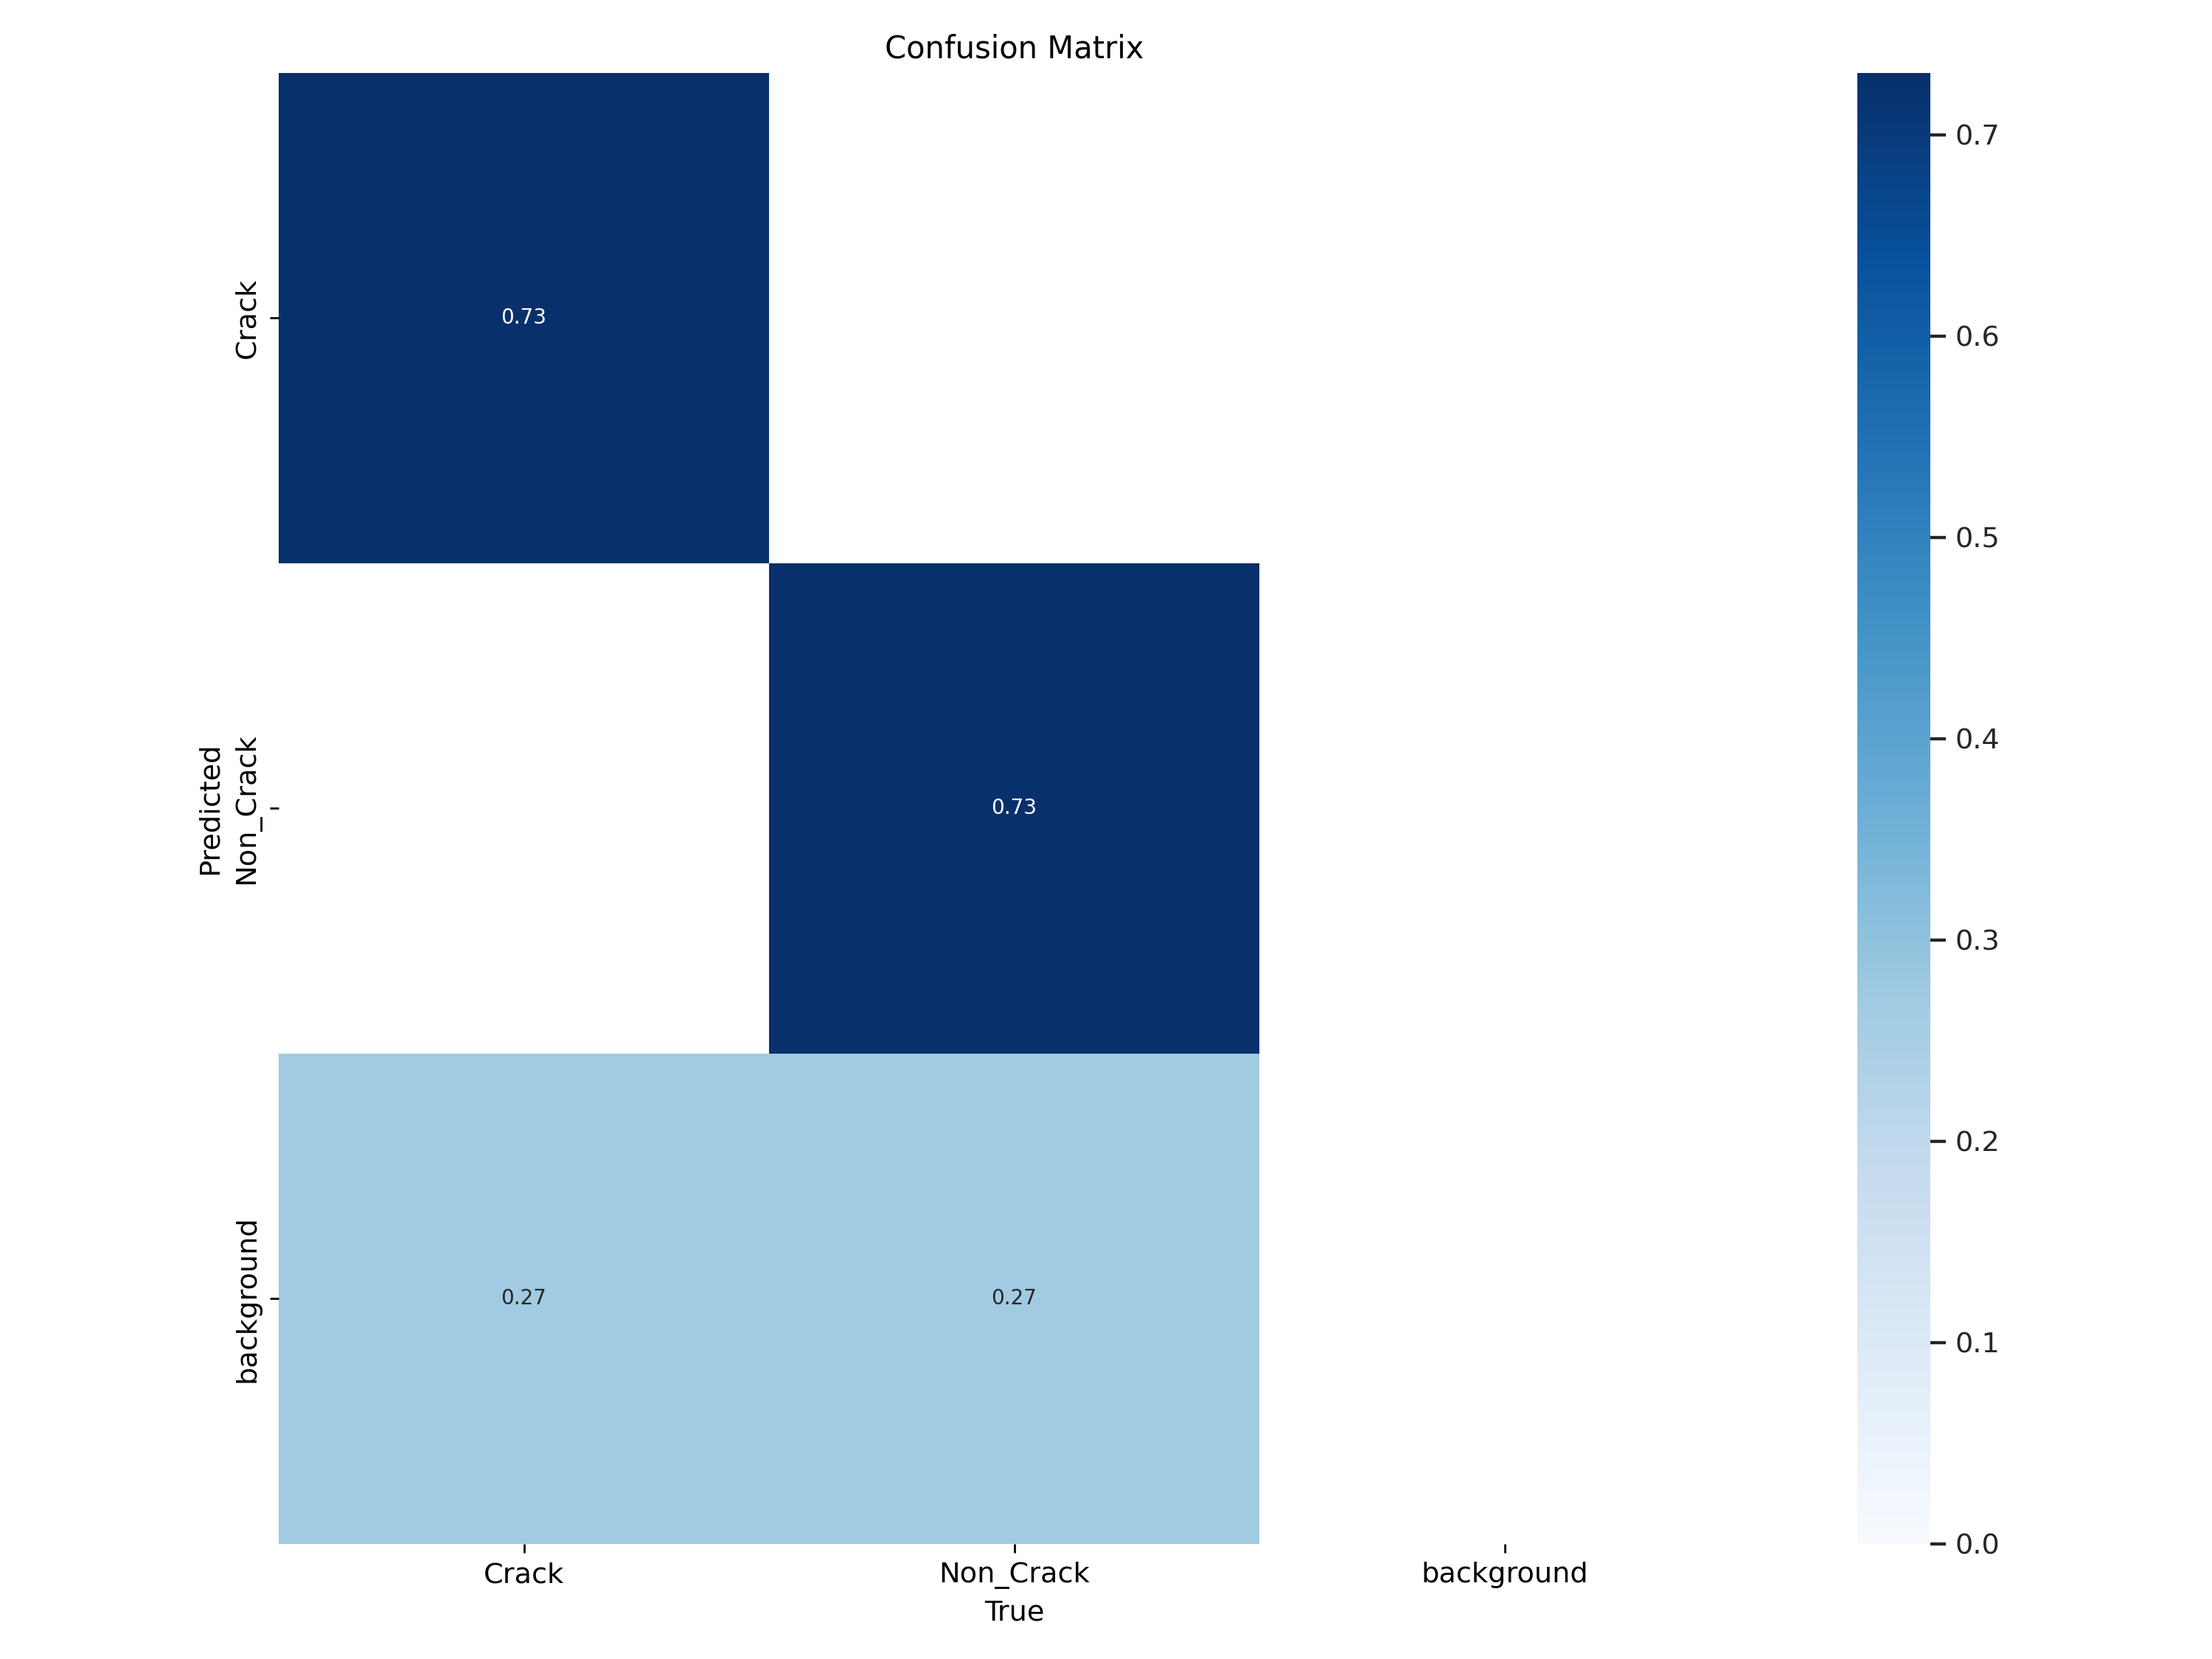

In [ ]:
image_path = '/content/yolov5/runs/train/yolov5s_result/confusion_matrix.png'
img = Image.open(image_path)

# Display the image using IPython.display
display(img)

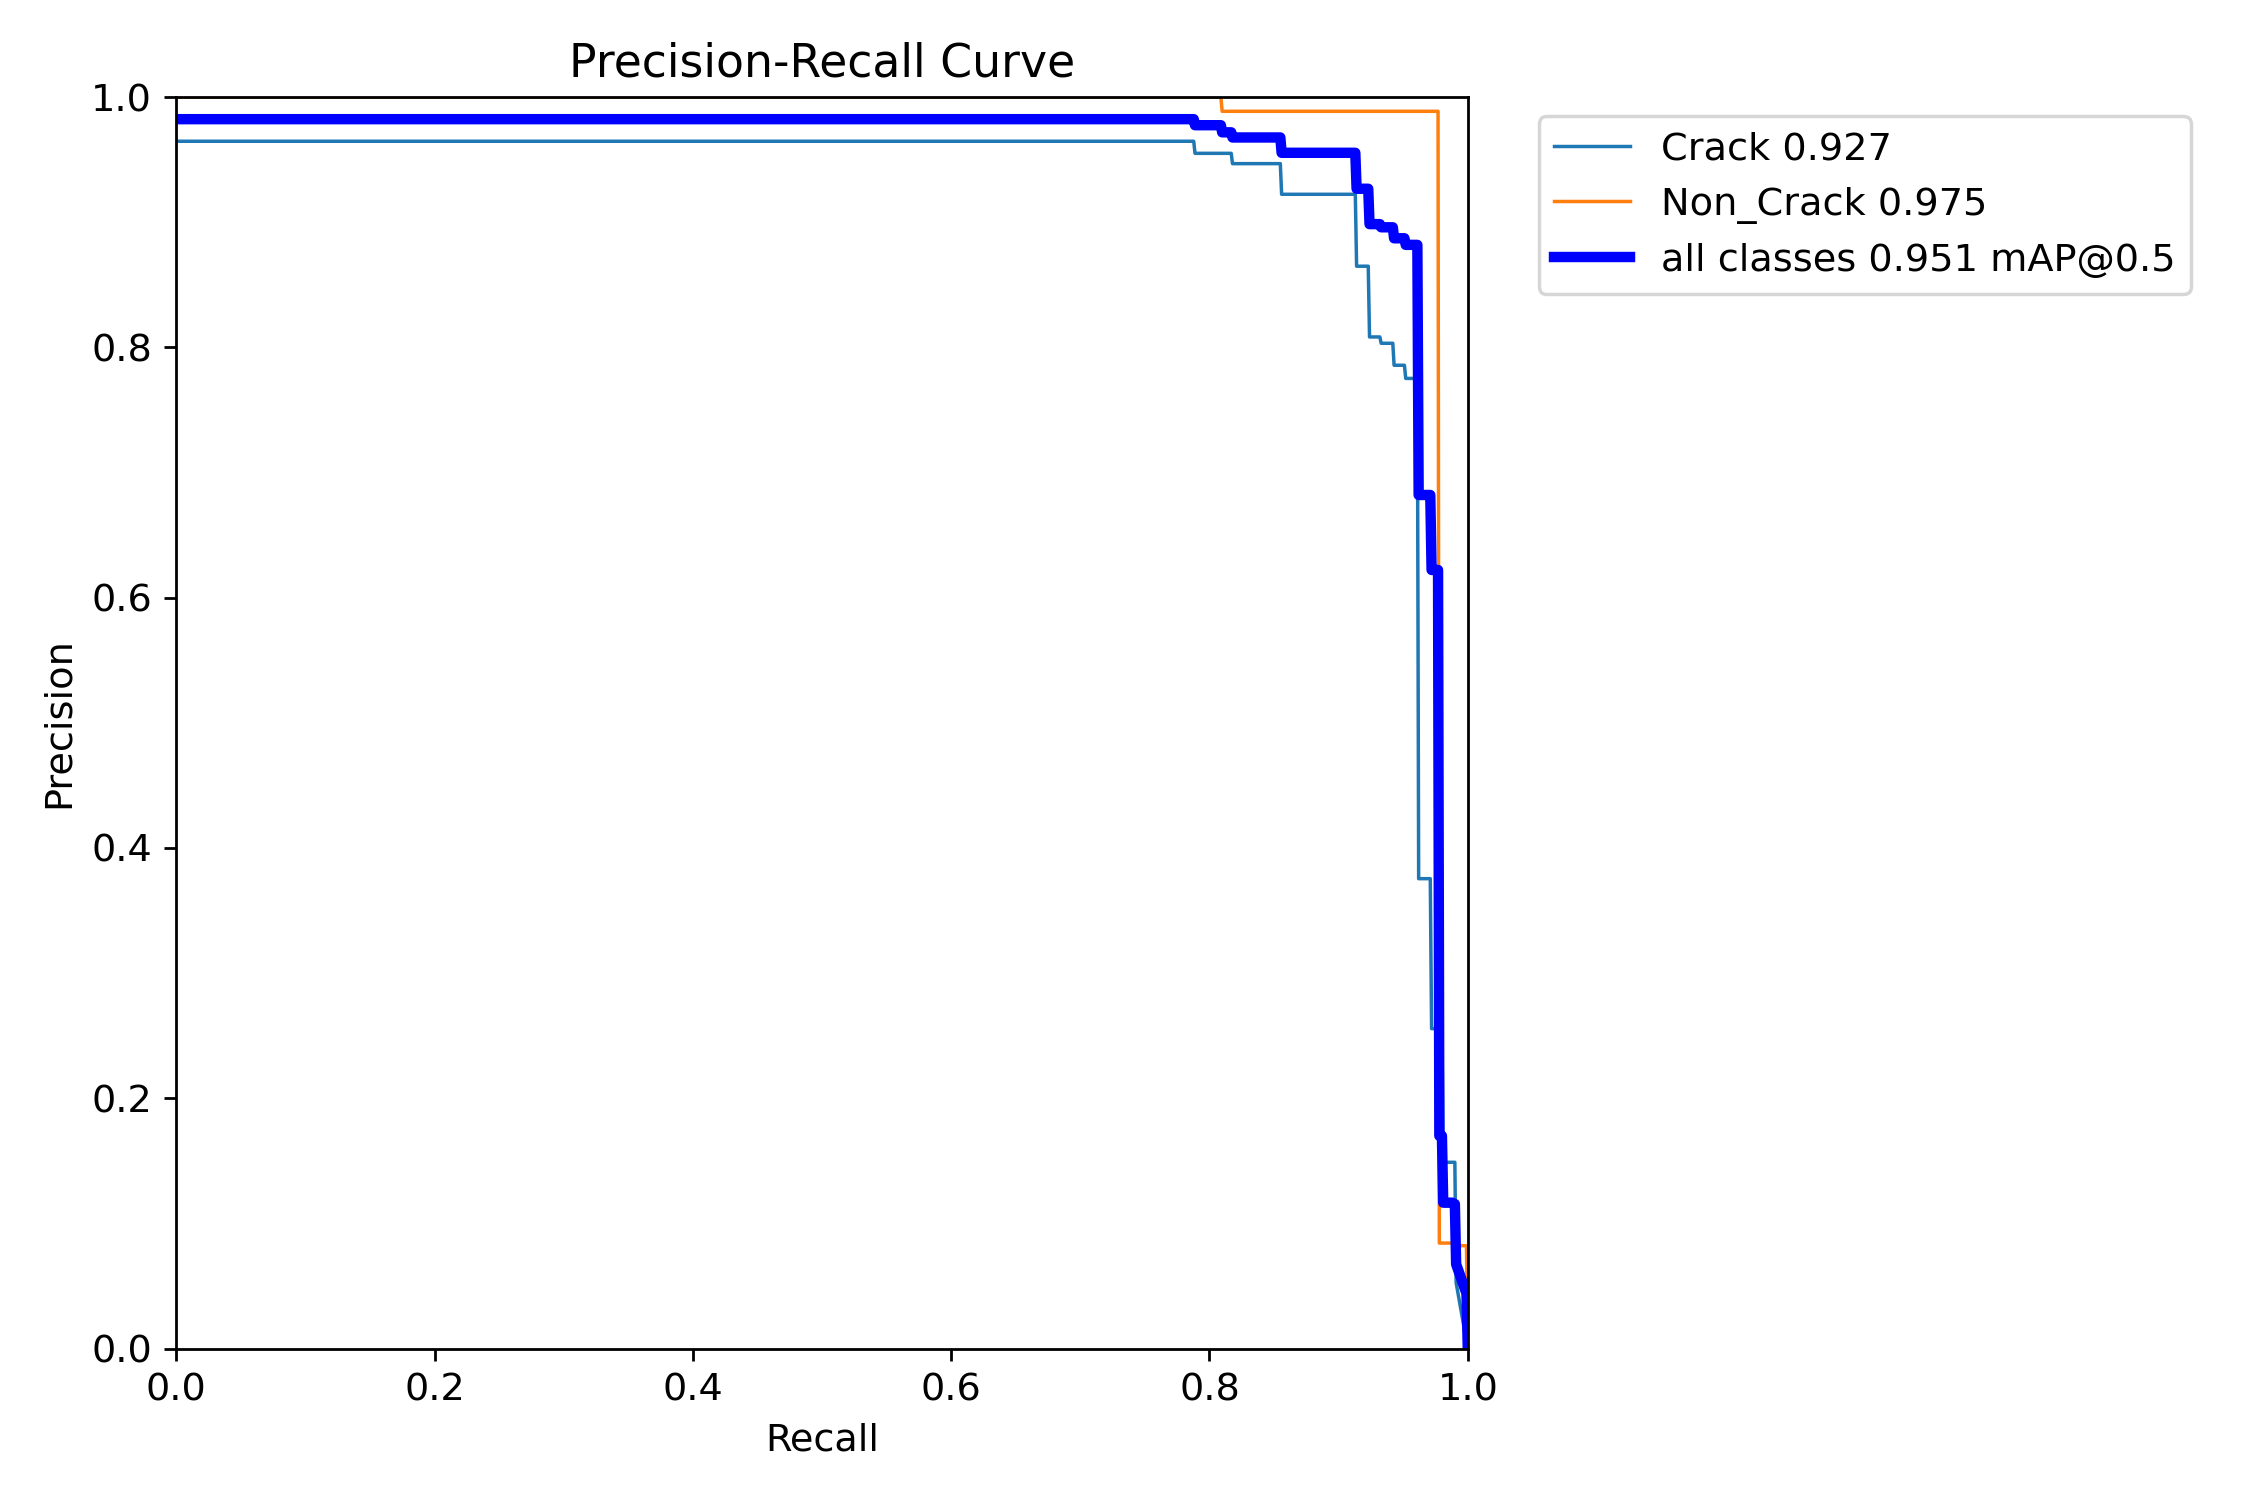

In [ ]:
image_path = '/content/yolov5/runs/train/yolov5s_result/PR_curve.png'
img = Image.open(image_path)

# Display the image using IPython.display
display(img)

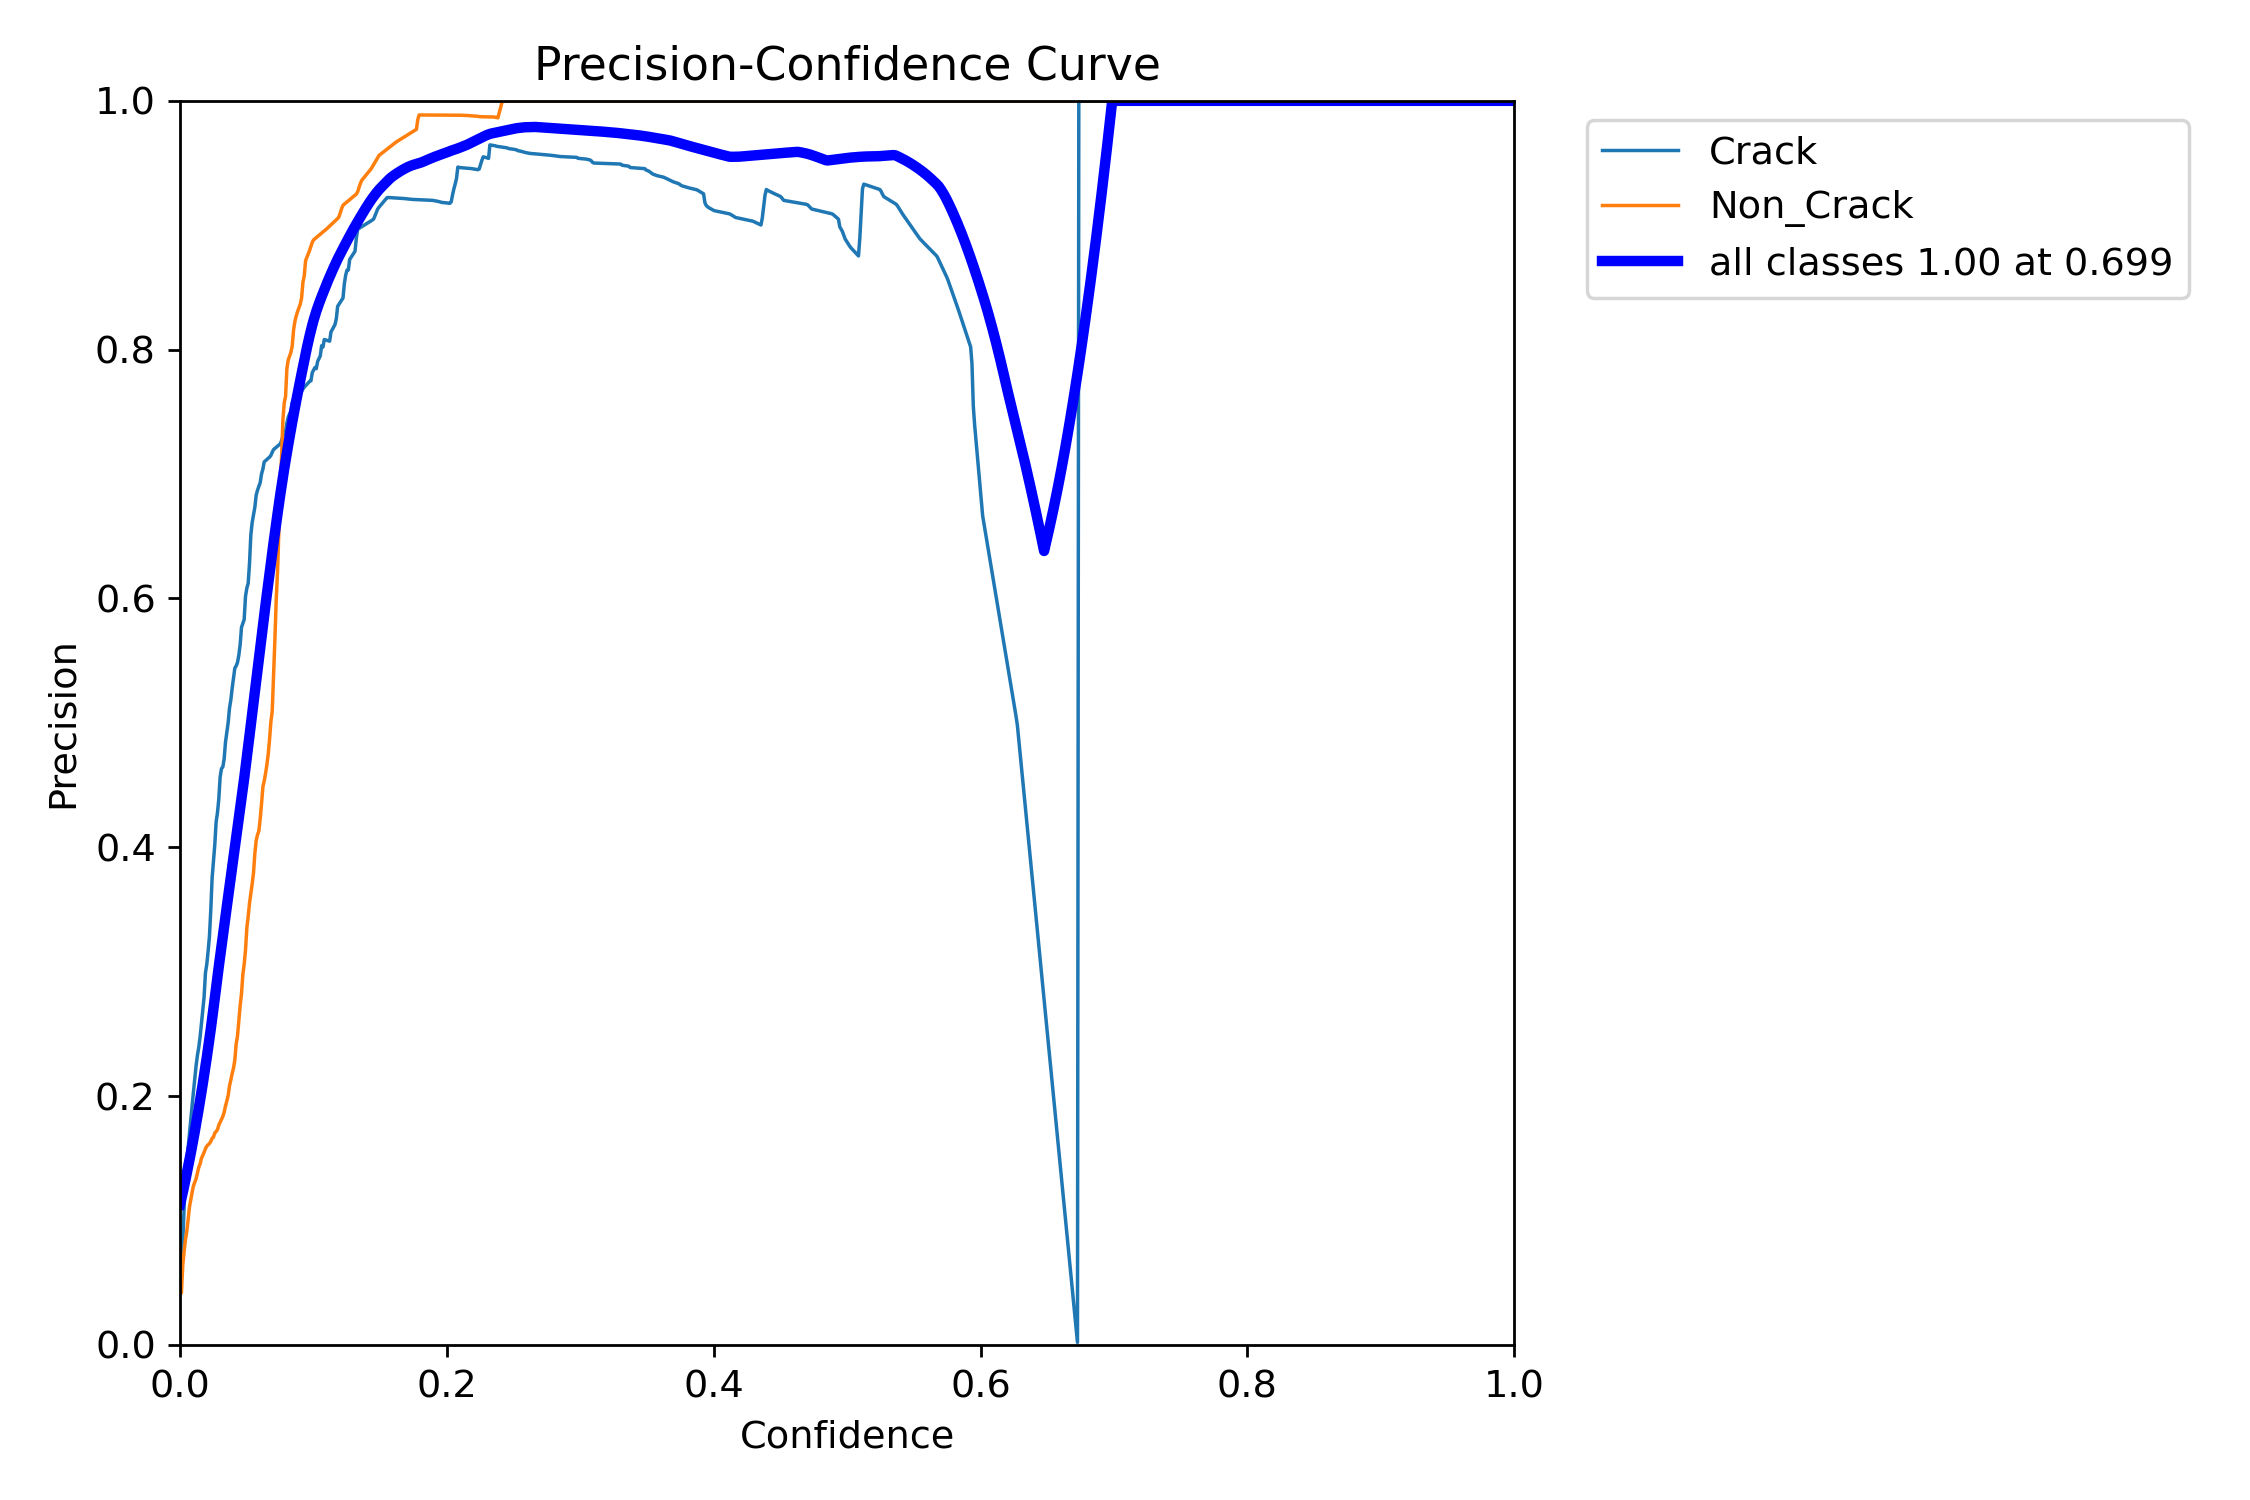

In [ ]:
image_path = '/content/yolov5/runs/train/yolov5s_result/P_curve.png'
img = Image.open(image_path)

# Display the image using IPython.display
display(img)

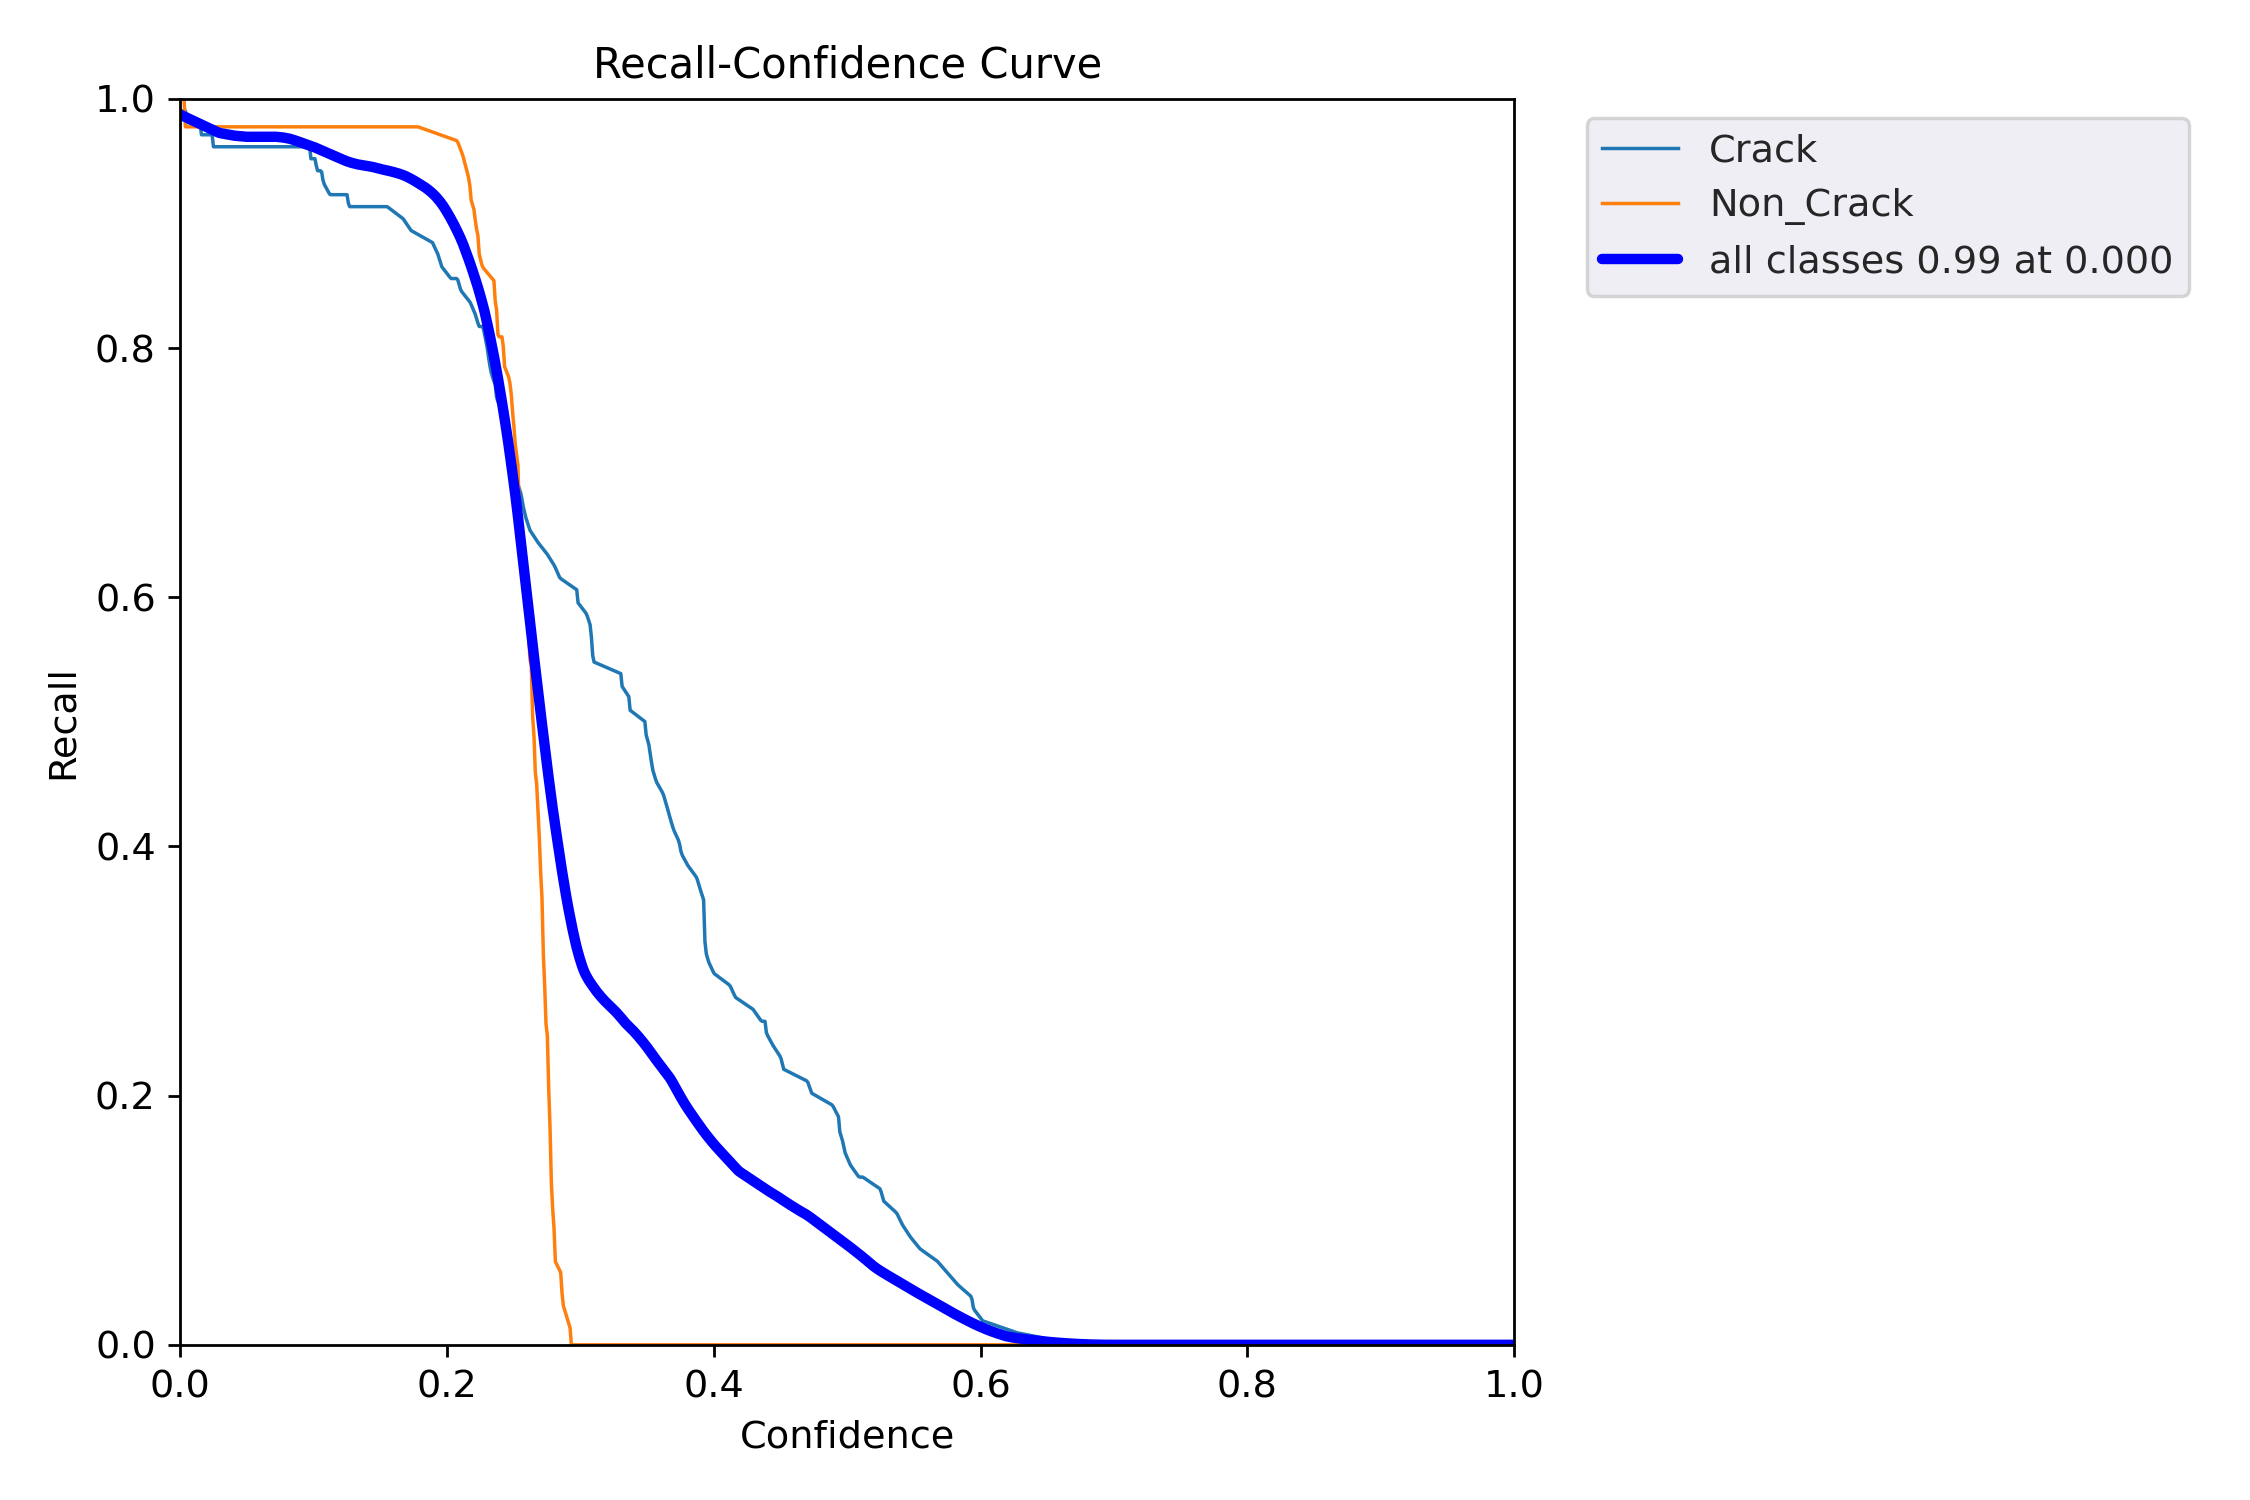

In [ ]:
image_path = '/content/yolov5/runs/train/yolov5s_result/R_curve.png'
img = Image.open(image_path)

# Display the image using IPython.display
display(img)

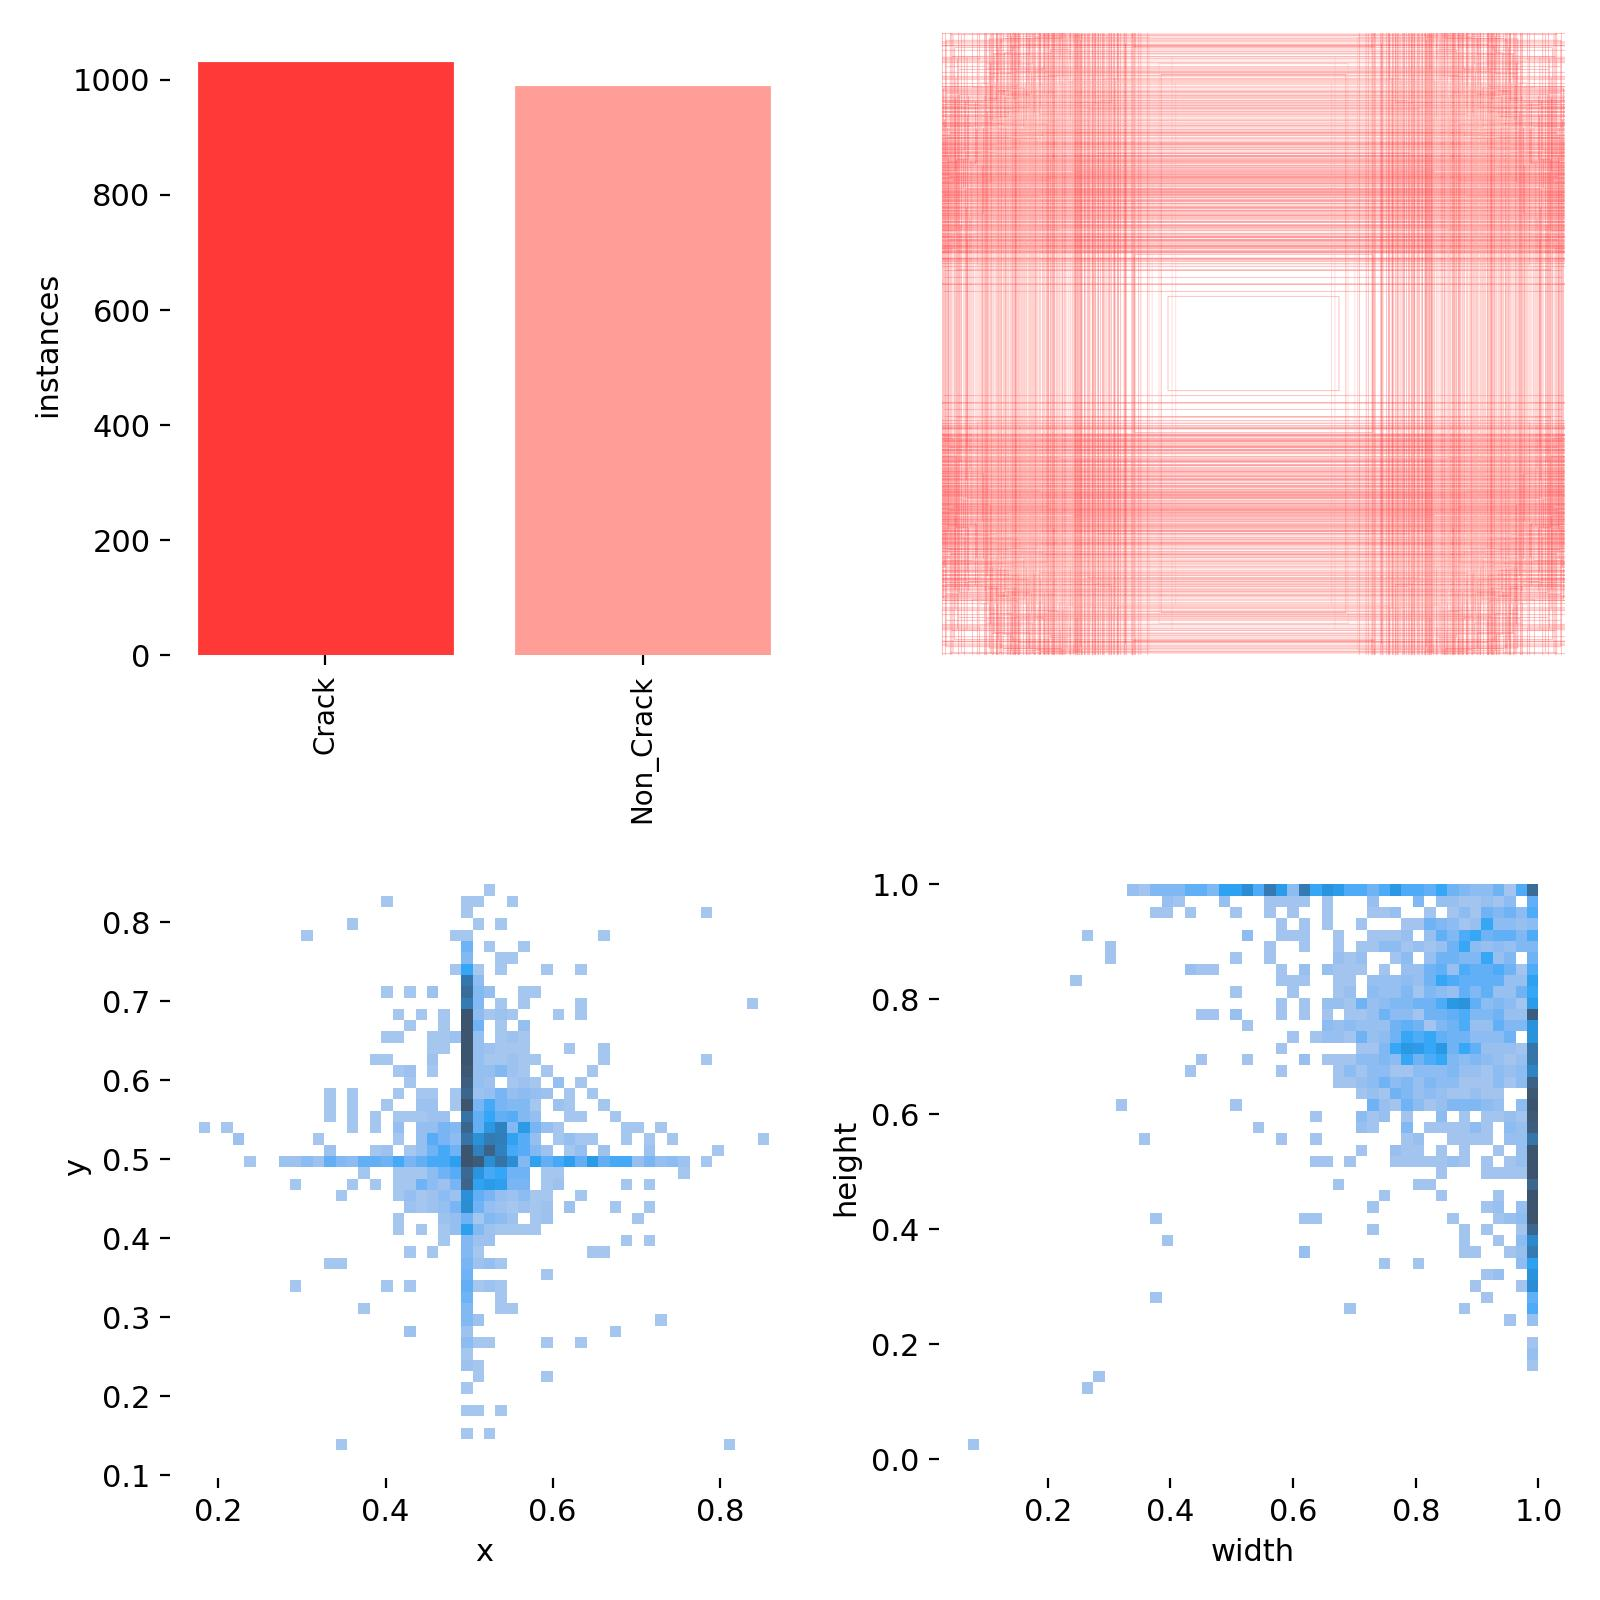

In [ ]:
image_path = '/content/yolov5/runs/train/yolov5s_result/labels.jpg'
img = Image.open(image_path)

# Display the image using IPython.display
display(img)

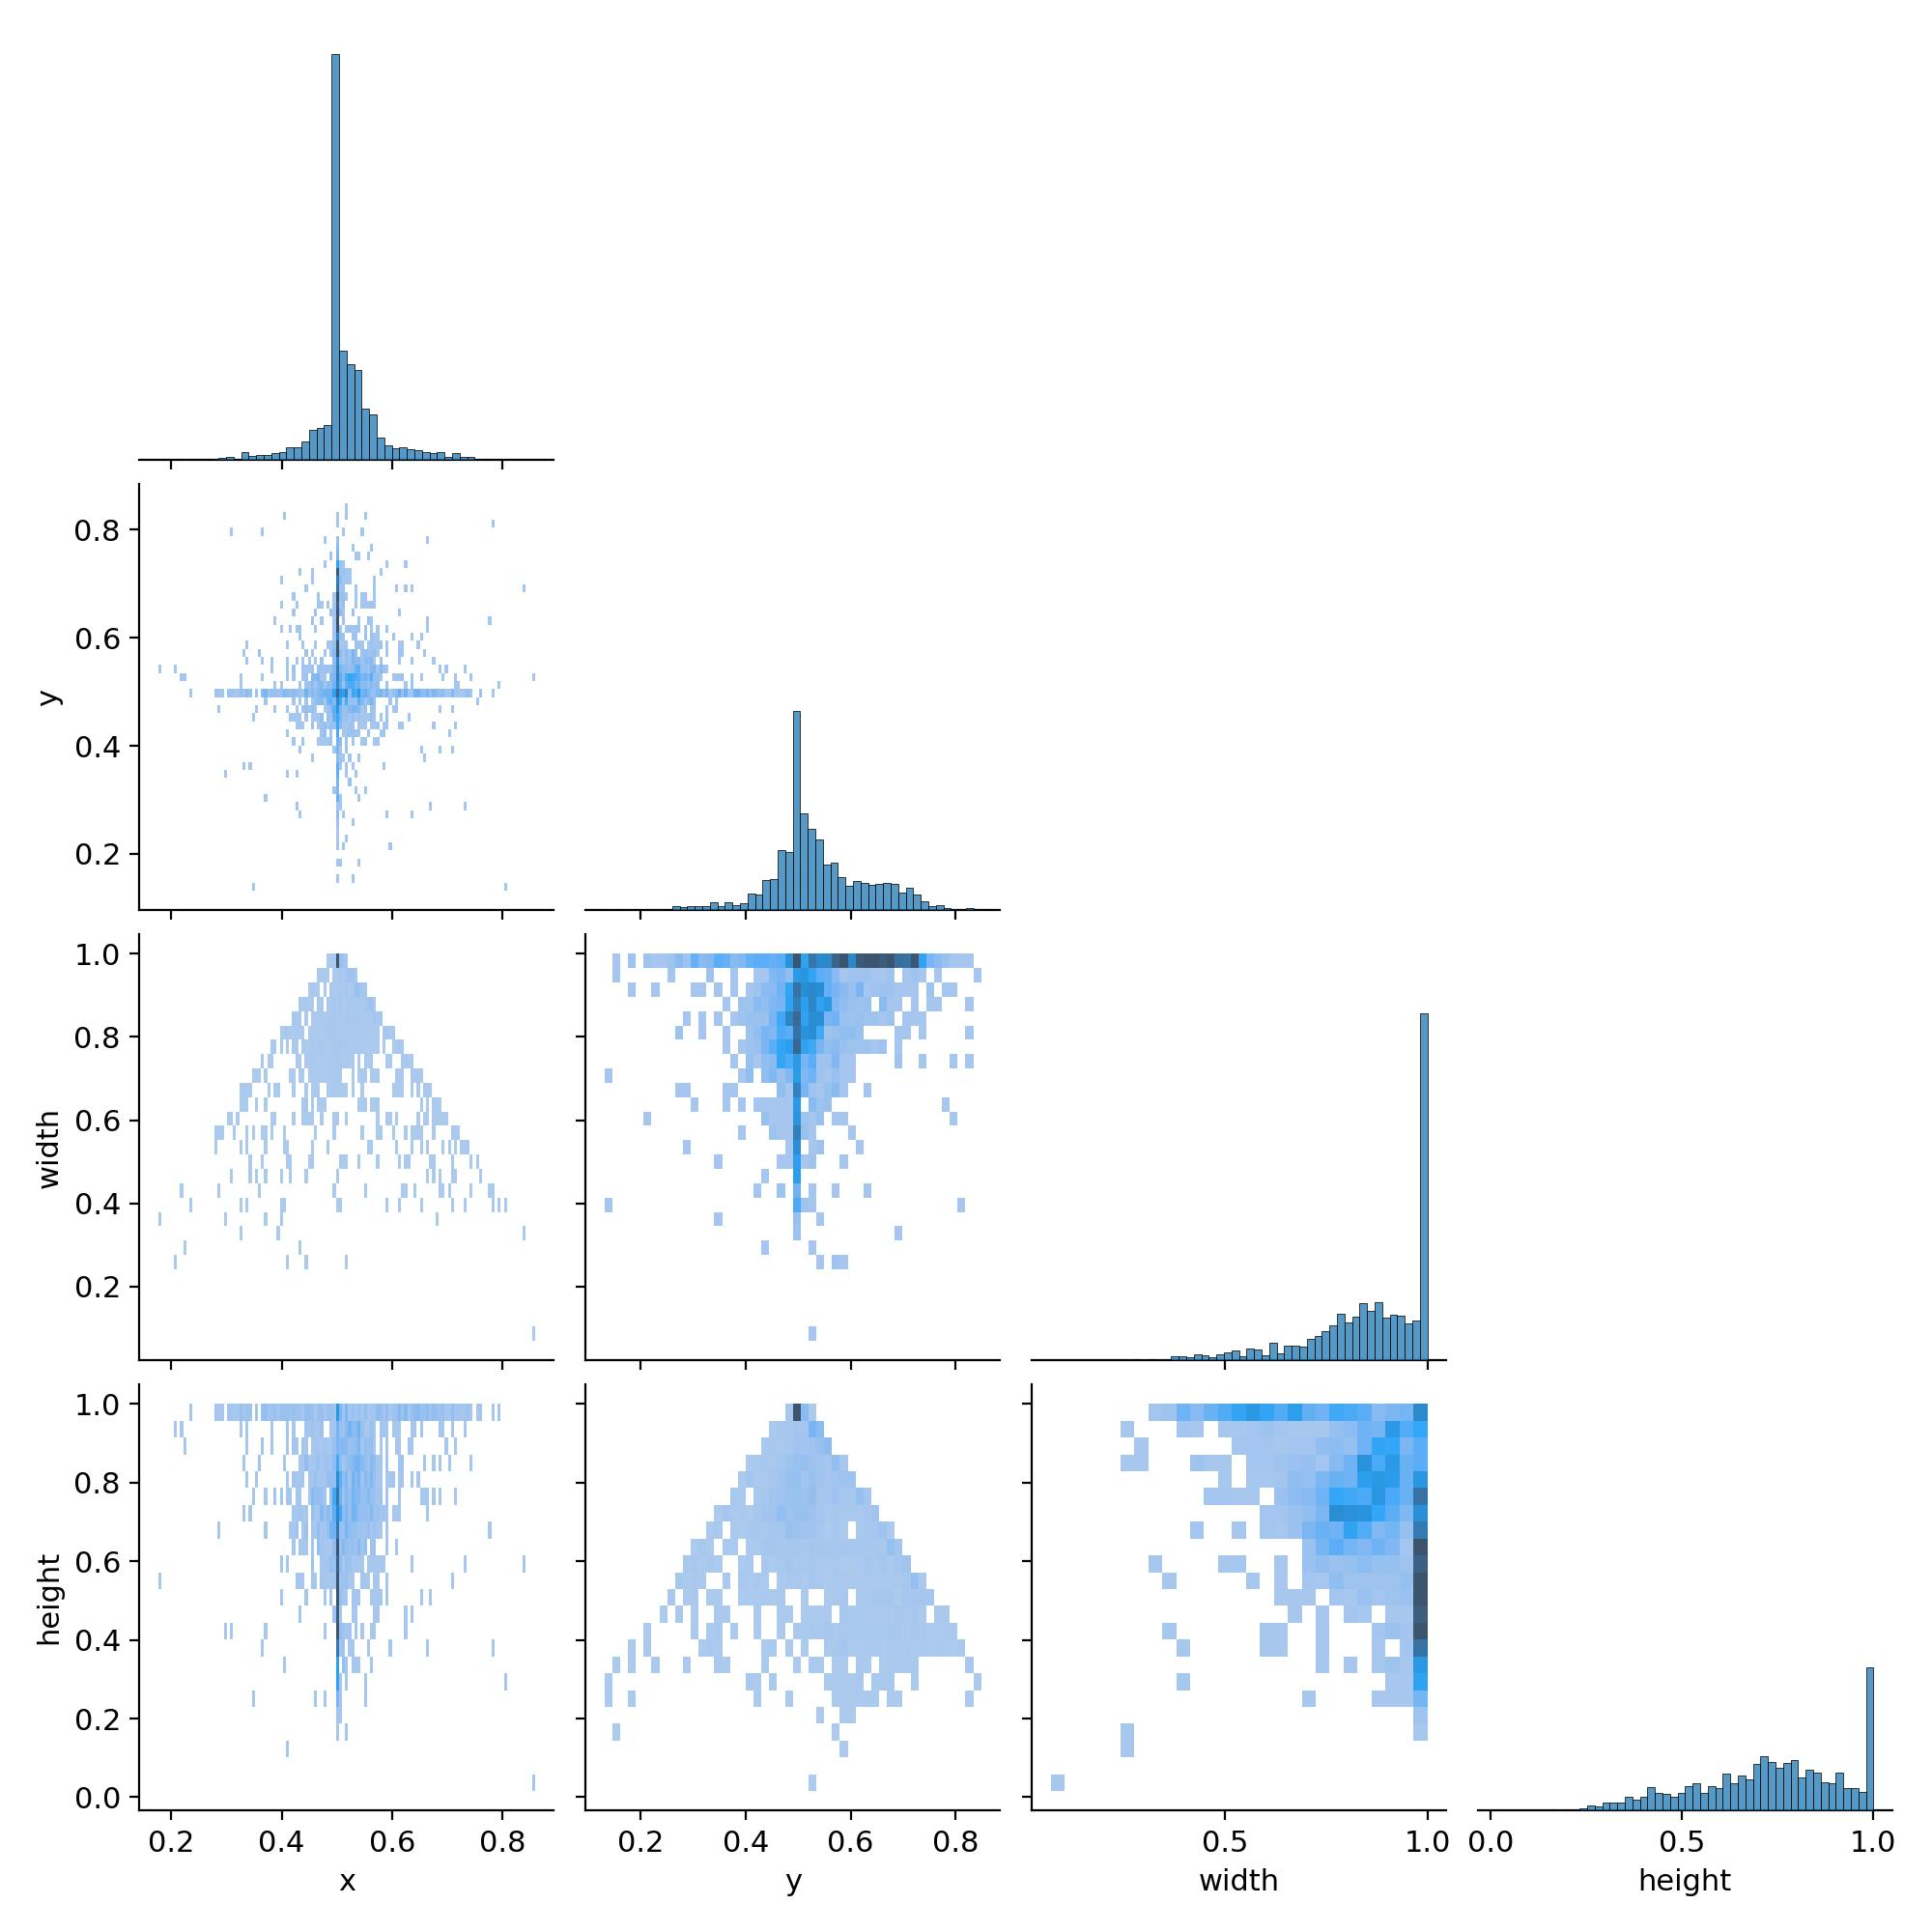

In [ ]:
image_path = '/content/yolov5/runs/train/yolov5s_result/labels_correlogram.jpg'
img = Image.open(image_path)

# Display the image using IPython.display
display(img)

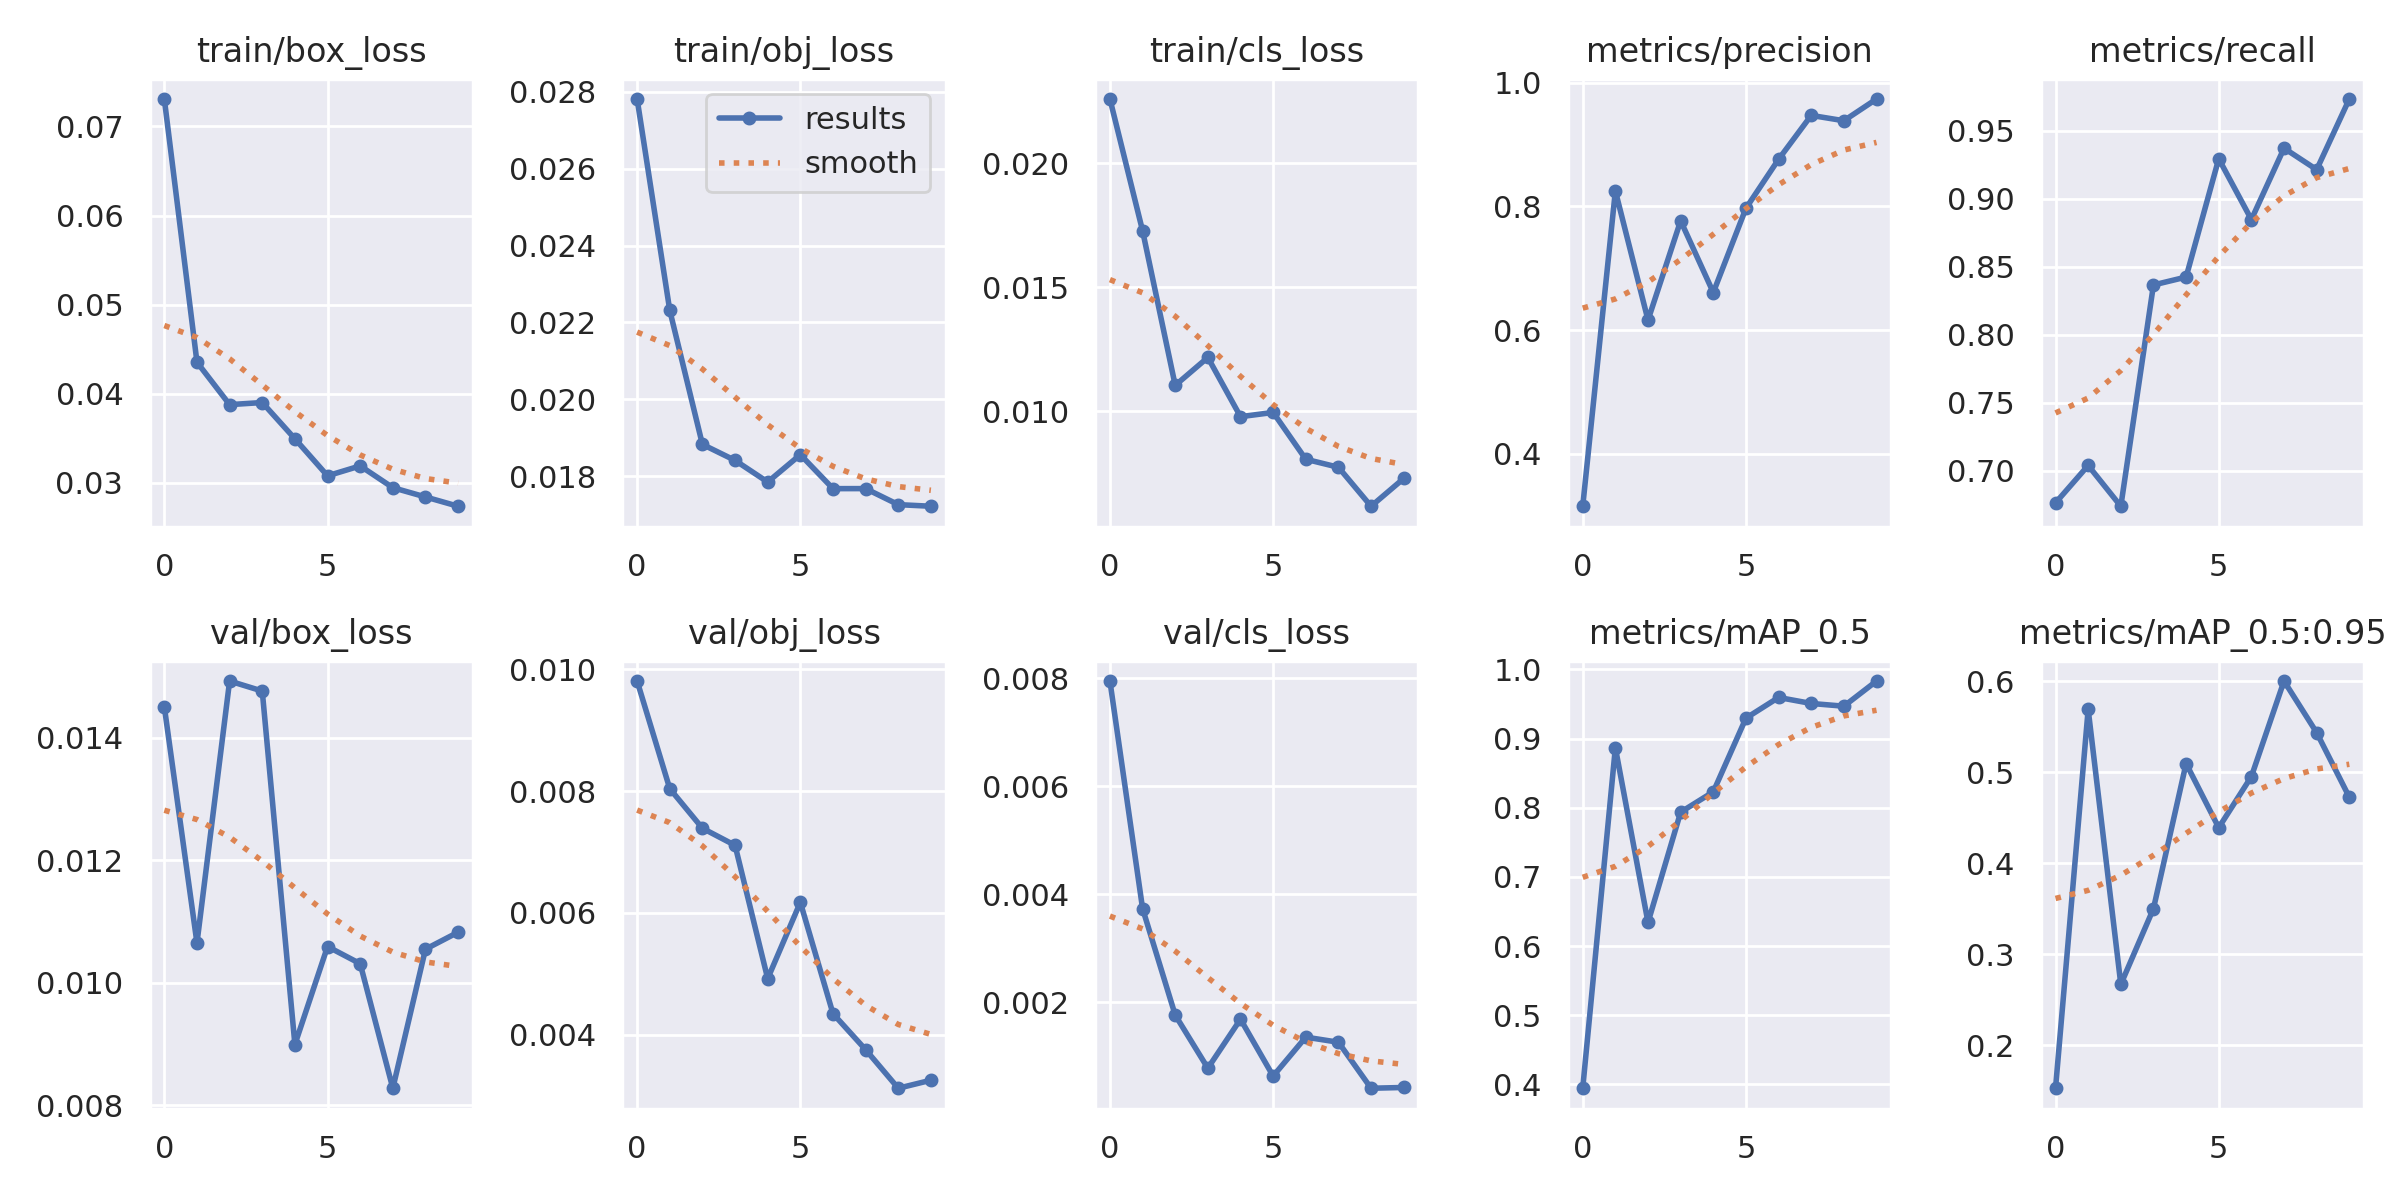

In [ ]:
image_path = '/content/yolov5/runs/train/yolov5s_result/results.png'
img = Image.open(image_path)

# Display the image using IPython.display
display(img)

Detection result:


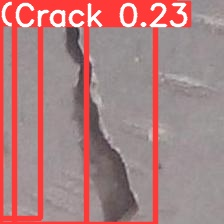

In [ ]:
image_path = '/content/yolov5/runs/detect/exp2/00011_jpg.rf.b610d7e2d5f7b5029270a32f736fbd1a.jpg'
img = Image.open(image_path)
print('Detection result:')
# Display the image using IPython.display
display(img)